# Подготовка датасета news

In [50]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
from tqdm.auto import tqdm
from tqdm import trange
import pickle

import scipy as sp
import string

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import nltk
# import scikitplot as skplt

import re, string

from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
STOPWORDS = set(stopwords.words('russian'))
#list of special characters.You can use regular expressions too
# importing the PorterStemmer
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize,word_tokenize
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
#importing the CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import SnowballStemmer

# from pymorphy2 import MorphAnalyzer

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

import gensim
from gensim.models import Word2Vec

# import fasttext
# from fasttext import train_supervised

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [39]:
import datetime
import pathlib
import glob

import random
from tabulate import tabulate
from collections import Counter

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset, RandomSampler, SequentialSampler

from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW
# from transformers.optimization import get_linear_scheduler_with_warmup

In [56]:
# ! pip install newspaper3k
from newspaper import Article

In [3]:
plt.style.use('ggplot')

In [ ]:
# !pip install fastText

In [4]:
sym1 = 'SBERP'
sym2 = 'SBER'

In [ ]:
# df_news = pd.read_csv(f'smartlab_{sym2}_new.csv')
# df_news['time'] = df_news['time'].map(lambda x: x[:10])
# df_news['time'] = pd.to_datetime(df_news['time'], format='%Y-%m-%d')
# df_news = df_news[['time', 'text']]
# df_news

In [ ]:
df_news1 = df_news['text'].groupby(df_news['time']).apply(list).reset_index()
df_news1['text'] = df_news1['text'].apply(lambda x: x[0])
df_news1.set_index('time', inplace=True)
df_news1 = df_news1[df_news1.index > "2016-01-01"]
df_news1

,text
time,
2016-01-13,Сегодня у нас проходит т.н. гайдаровский форум...
2016-01-15,Сбер представил отчет по РСБУ. Вклады населени...
2016-01-18,Мы будем предлагатьсказал Улюкаев. Чтобы прив...
2016-01-20,"Здравствуйте, сегодня наткнулся на ткую новост..."
2016-01-21,"Коммерсант сегодня написал, что Керимов хочет ..."
...,...
2023-11-29,Сбербанк отмечает улучшение ситуации с реструк...
2023-11-30,Правительство России распространило действие п...
2023-12-01,Совкомбанк занимает 8 место по активам среди р...


In [ ]:
df_stock = pd.read_csv(f'{sym1}_day.csv', index_col=0, parse_dates=True)
df_stock = df_stock[['CLOSE']]
df_stock = df_stock[df_stock.index > "2016-01-01"]
df_stock

,CLOSE
DATE,
2016-01-04,73.88
2016-01-05,74.23
2016-01-06,72.62
2016-01-11,69.11
2016-01-12,69.32
...,...
2023-11-28,279.60
2023-11-29,276.79
2023-11-30,276.95


In [ ]:
df = pd.concat([df_stock, df_news1], axis=1)
df

,CLOSE,text
2016-01-04,73.88,NaN
2016-01-05,74.23,NaN
2016-01-06,72.62,NaN
2016-01-11,69.11,NaN
2016-01-12,69.32,NaN
...,...,...
2023-11-29,276.79,Сбербанк отмечает улучшение ситуации с реструк...
2023-11-30,276.95,Правительство России распространило действие п...
2023-12-01,273.85,Совкомбанк занимает 8 место по активам среди р...
2023-12-02,NaN,Правительство принимает «некоторые меры» для п...


In [ ]:
df.isna().sum()

CLOSE     57
text     576
dtype: int64

In [ ]:
df['CLOSE'].fillna(method='ffill', inplace=True)

In [ ]:
df['Target'] = df['CLOSE'] - df['CLOSE'].shift()
df['TargetClass'] = [1 if df.Target[i] > 0 else 0 for i in range(len(df))]
df

,CLOSE,text,Target,TargetClass
2016-01-04,73.88,NaN,NaN,0
2016-01-05,74.23,NaN,0.35,1
2016-01-06,72.62,NaN,-1.61,0
2016-01-11,69.11,NaN,-3.51,0
2016-01-12,69.32,NaN,0.21,1
...,...,...,...,...
2023-11-29,276.79,Сбербанк отмечает улучшение ситуации с реструк...,-2.81,0
2023-11-30,276.95,Правительство России распространило действие п...,0.16,1
2023-12-01,273.85,Совкомбанк занимает 8 место по активам среди р...,-3.10,0
2023-12-02,273.85,Правительство принимает «некоторые меры» для п...,0.00,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2041 entries, 2016-01-04 to 2023-12-04
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   CLOSE        2041 non-null   float64
 1   text         1465 non-null   object 
 2   Target       2040 non-null   float64
 3   TargetClass  2041 non-null   int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 79.7+ KB


In [ ]:
df = df.dropna()
df = df[['text', 'TargetClass']].reset_index(drop = True)
df

,text,TargetClass
0,Сегодня у нас проходит т.н. гайдаровский форум...,1
1,Сбер представил отчет по РСБУ. Вклады населени...,0
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0
4,"Коммерсант сегодня написал, что Керимов хочет ...",1
...,...,...
1460,Сбербанк отмечает улучшение ситуации с реструк...,0
1461,Правительство России распространило действие п...,1
1462,Совкомбанк занимает 8 место по активам среди р...,0
1463,Правительство принимает «некоторые меры» для п...,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         1465 non-null   object
 1   TargetClass  1465 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.0+ KB


In [ ]:
df.to_csv(f'{sym1}_dataset_news.csv', index = False)

In [ ]:
# pd.read_csv(f'{sym1}_dataset_news.csv')

In [ ]:
df['TargetClass'].value_counts()

1    743
0    722
Name: TargetClass, dtype: int64

# Предпроцессинг

In [ ]:
ps = SnowballStemmer(language="russian")
lemmatizer = MorphAnalyzer()

In [ ]:
data = df.rename({'TargetClass':'Class','text':'Message'},axis=1)
data

,Message,Class
2016-01-13,Сегодня у нас проходит т.н. гайдаровский форум...,1
2016-01-15,Сбер представил отчет по РСБУ. Вклады населени...,0
2016-01-18,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0
2016-01-20,"Здравствуйте, сегодня наткнулся на ткую новост...",0
2016-01-21,"Коммерсант сегодня написал, что Керимов хочет ...",1
...,...,...
2023-11-24,"Как узнал “Ъ”, крупные банки исчерпали лимиты ...",1
2023-11-27,Динамика рынка POS-кредитования (point of sale...,0
2023-11-28,"«Банки вернулись в хорошую форму, пора думать ...",0
2023-11-29,Сбербанк отмечает улучшение ситуации с реструк...,0


In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]+|[\d]+', r'',text).strip()
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub(' ', text)
#     text = re.sub(r'[^0-9a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = " ".join(word for word in text.split() if word not in STOPWORDS)
    text = " ".join(ps.stem(lemmatizer.normal_forms(word)[0]) for word in text.split())
    return text

data['clean_text'] = data['Message'].apply(clean_text)
data.head()

In [ ]:
#define a function to get rid of stopwords present in the messages
def message_text_process(mess):
    # Check characters to see if there are punctuations
    no_punctuation=[char for char in mess if char not in string.punctuation]
    # now form the sentence
    no_punctuation=''.join(no_punctuation)
    # Now eliminate any stopwords
    return[word for word in no_punctuation.split() if word.lower() not in stopwords.words('english') and stopwords.words('russian')]

# to verify that function is working
data['Message_text_process'] = data['Message'].apply(message_text_process)
data

,Message,Class,clean_text,Message_text_process
2016-01-13,Сегодня у нас проходит т.н. гайдаровский форум...,1,сегодн проход тн гайдаровск форум дела различн...,"[Сегодня, у, нас, проходит, тн, гайдаровский, ..."
2016-01-15,Сбер представил отчет по РСБУ. Вклады населени...,0,сбер представ отчет рсб вклад населен трлн руб...,"[Сбер, представил, отчет, по, РСБУ, Вклады, на..."
2016-01-18,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0,быт предлагатьсказа улюка приватизирова сбер к...,"[Мы, будем, предлагатьсказал, Улюкаев, Чтобы, ..."
2016-01-20,"Здравствуйте, сегодня наткнулся на ткую новост...",0,здравств сегодн наткнут ткова новостьбумаг пер...,"[Здравствуйте, сегодня, наткнулся, на, ткую, н..."
2016-01-21,"Коммерсант сегодня написал, что Керимов хочет ...",1,коммерсант сегодн написа кер хотет обкеш компа...,"[Коммерсант, сегодня, написал, что, Керимов, х..."
...,...,...,...,...
2023-11-23,Прирост ипотечного портфеля в 2023г превысил 3...,0,прирост ипотечн портфел г превыс трлн руб г тр...,"[Прирост, ипотечного, портфеля, в, 2023г, прев..."
2023-11-24,"Как узнал “Ъ”, крупные банки исчерпали лимиты ...",1,узна ь крупн банк исчерпа лим финансирован льг...,"[Как, узнал, “Ъ”, крупные, банки, исчерпали, л..."
2023-11-27,Динамика рынка POS-кредитования (point of sale...,0,динамик рынок поскредитован point of sales кре...,"[Динамика, рынка, POSкредитования, point, sale..."
2023-11-28,"«Банки вернулись в хорошую форму, пора думать ...",0,банк вернут хорош форм пор дума развит сообщ п...,"[«Банки, вернулись, в, хорошую, форму, пора, д..."


In [ ]:
data['Message_clean_text_process'] = data['clean_text'].apply(message_text_process)
data

,Message,Class,clean_text,Message_text_process,Message_clean_text_process
2016-01-13,Сегодня у нас проходит т.н. гайдаровский форум...,1,сегодн проход тн гайдаровск форум дела различн...,"[Сегодня, у, нас, проходит, тн, гайдаровский, ...","[сегодн, проход, тн, гайдаровск, форум, дела, ..."
2016-01-15,Сбер представил отчет по РСБУ. Вклады населени...,0,сбер представ отчет рсб вклад населен трлн руб...,"[Сбер, представил, отчет, по, РСБУ, Вклады, на...","[сбер, представ, отчет, рсб, вклад, населен, т..."
2016-01-18,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0,быт предлагатьсказа улюка приватизирова сбер к...,"[Мы, будем, предлагатьсказал, Улюкаев, Чтобы, ...","[быт, предлагатьсказа, улюка, приватизирова, с..."
2016-01-20,"Здравствуйте, сегодня наткнулся на ткую новост...",0,здравств сегодн наткнут ткова новостьбумаг пер...,"[Здравствуйте, сегодня, наткнулся, на, ткую, н...","[здравств, сегодн, наткнут, ткова, новостьбума..."
2016-01-21,"Коммерсант сегодня написал, что Керимов хочет ...",1,коммерсант сегодн написа кер хотет обкеш компа...,"[Коммерсант, сегодня, написал, что, Керимов, х...","[коммерсант, сегодн, написа, кер, хотет, обкеш..."
...,...,...,...,...,...
2023-11-23,Прирост ипотечного портфеля в 2023г превысил 3...,0,прирост ипотечн портфел г превыс трлн руб г тр...,"[Прирост, ипотечного, портфеля, в, 2023г, прев...","[прирост, ипотечн, портфел, г, превыс, трлн, р..."
2023-11-24,"Как узнал “Ъ”, крупные банки исчерпали лимиты ...",1,узна ь крупн банк исчерпа лим финансирован льг...,"[Как, узнал, “Ъ”, крупные, банки, исчерпали, л...","[узна, ь, крупн, банк, исчерпа, лим, финансиро..."
2023-11-27,Динамика рынка POS-кредитования (point of sale...,0,динамик рынок поскредитован point of sales кре...,"[Динамика, рынка, POSкредитования, point, sale...","[динамик, рынок, поскредитован, point, sales, ..."
2023-11-28,"«Банки вернулись в хорошую форму, пора думать ...",0,банк вернут хорош форм пор дума развит сообщ п...,"[«Банки, вернулись, в, хорошую, форму, пора, д...","[банк, вернут, хорош, форм, пор, дума, развит,..."


# TF-IDF BOW

In [ ]:
X = data['clean_text']
y = data['Class']

In [ ]:
def Model(model, X, y):
#training and testing the data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # model building using CountVectorizer and TfidfTransformer
    pipeline_model = Pipeline([('vect', CountVectorizer(ngram_range = (1,3))),
#                                ('TfidfVect', TfidfVectorizer()),
                              ('tfidf', TfidfTransformer()),
                              ('clf', model)])
    pipeline_model.fit(x_train, y_train)




    y_pred = pipeline_model.predict(x_test)
    y_probas =pipeline_model.predict_proba(x_test)
    skplt.metrics.plot_roc(y_test,y_probas,figsize=(12,8),title_fontsize=12,text_fontsize=16)
    plt.show()
    skplt.metrics.plot_precision_recall(y_test,y_probas,figsize=(12,8),title_fontsize=12,text_fontsize=16)
    plt.show()
    print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
    print("Classification Report is:\n",classification_report(y_test, y_pred))
    print('Accuracy:', pipeline_model.score(x_test, y_test)*100)
    print("Training Score:\n",pipeline_model.score(x_train,y_train)*100)

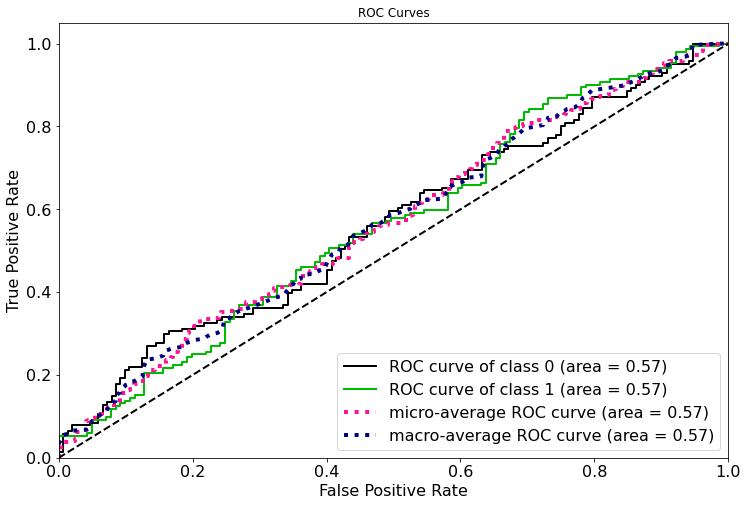

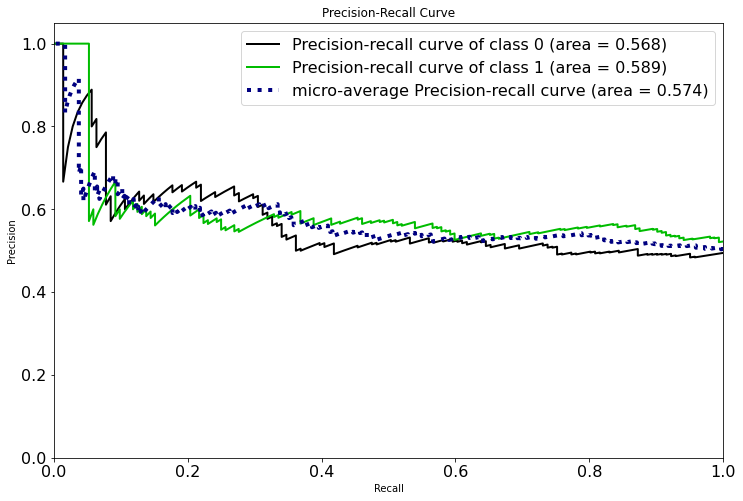

Confusion Matrix:
 [[72 69]
 [65 87]]
Classification Report is:
               precision    recall  f1-score   support

           0       0.53      0.51      0.52       141
           1       0.56      0.57      0.56       152

    accuracy                           0.54       293
   macro avg       0.54      0.54      0.54       293
weighted avg       0.54      0.54      0.54       293

Accuracy: 54.26621160409556
Training Score:
 99.7431506849315
CPU times: total: 9.27 s
Wall time: 6.68 s


In [ ]:
%%time
model1 = LogisticRegression()
Model(model1, X, y)

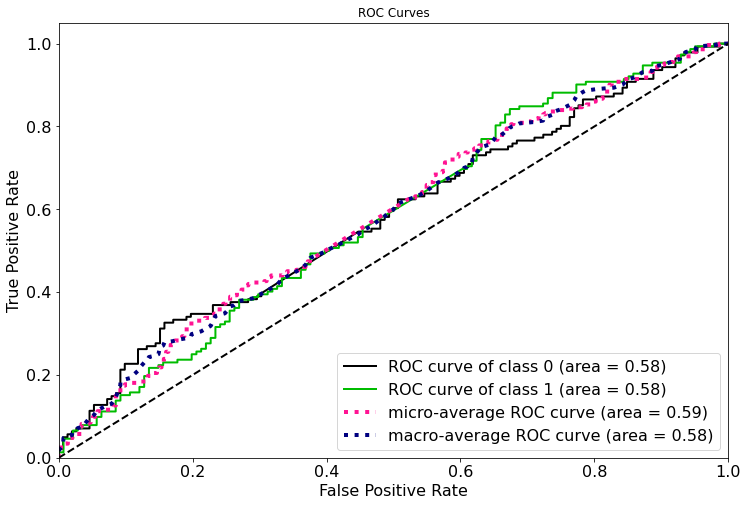

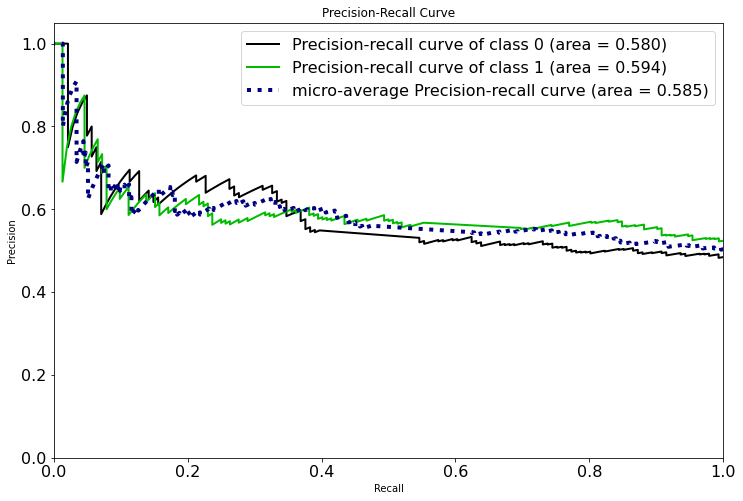

Confusion Matrix:
 [[74 67]
 [65 87]]
Classification Report is:
               precision    recall  f1-score   support

           0       0.53      0.52      0.53       141
           1       0.56      0.57      0.57       152

    accuracy                           0.55       293
   macro avg       0.55      0.55      0.55       293
weighted avg       0.55      0.55      0.55       293

Accuracy: 54.94880546075085
Training Score:
 99.7431506849315
CPU times: total: 26 s
Wall time: 26.3 s


In [ ]:
%%time
model2 = SVC(kernel='linear',probability=True)
Model(model2, X, y)

In [ ]:
#function for the model building and prediction
def Model1(model, X, y):
#training and testing the data
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # model building using CountVectorizer and TfidfTransformer
    pipeline_model = Pipeline([('vect', CountVectorizer(ngram_range = (1,3))),
                              ('tfidf', TfidfTransformer()),
                              ('clf', model)])
    pipeline_model.fit(x_train, y_train)




    y_pred = pipeline_model.predict(x_test)
    print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred))
    print("Classification Report is:\n",classification_report(y_test, y_pred))
    print('Accuracy:', pipeline_model.score(x_test, y_test)*100)
    print("Training Score:\n",pipeline_model.score(x_train,y_train)*100)

In [ ]:
%%time
model3 = LinearSVC()
Model1(model3, X, y)

Confusion Matrix:
 [[75 66]
 [66 86]]
Classification Report is:
               precision    recall  f1-score   support

           0       0.53      0.53      0.53       141
           1       0.57      0.57      0.57       152

    accuracy                           0.55       293
   macro avg       0.55      0.55      0.55       293
weighted avg       0.55      0.55      0.55       293

Accuracy: 54.94880546075085
Training Score:
 100.0
CPU times: total: 3.89 s
Wall time: 3.97 s


In [ ]:
with open("model1.pkl", "wb") as f:
    pickle.dump(model1, f)

with open("model2.pkl", "wb") as f:
    pickle.dump(model2, f)

with open("model3.pkl", "wb") as f:
    pickle.dump(model3, f)

In [ ]:
# with open("model.pkl", "rb") as f:
#     model = pickle.load(f)

# Word2Vec

https://colab.research.google.com/github/PragmaticsLab/NLP-course-FinTech/blob/master/seminars/2/2_embeddings.ipynb
https://python-school.ru/blog/word2vec-with-examples-in-gensim/

### обучаем свою модель

In [ ]:
#define a function to get rid of stopwords present in the messages
def message_text_process11(text):
    text = re.sub(r'http\S+', '', text)
    text = text.lower()
    text = re.sub(r'[^\w\s]+|[\d]+', r'',text).strip()
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub(' ', text)
# #     text = re.sub(r'[^0-9a-zA-Z]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
#     text = " ".join(word for word in text.split() if word not in STOPWORDS)
    text = " ".join(lemmatizer.normal_forms(word)[0] for word in text.split())

    # Check characters to see if there are punctuations
    no_punctuation=[char for char in text if char not in string.punctuation]
    # now form the sentence
    no_punctuation=''.join(no_punctuation)



    # Now eliminate any stopwords
    return[word for word in no_punctuation.split() if word.lower() not in stopwords.words('english') and stopwords.words('russian')]

# to verify that function is working
data1 = data['Message'].apply(message_text_process11)
data1

2016-01-13    [сегодня, у, мы, проходить, тн, гайдаровский, ...
2016-01-15    [сбер, представить, отчёт, по, рсб, вклад, нас...
2016-01-18    [мы, быть, предлагатьсказать, улюкай, чтобы, п...
2016-01-20    [здравствуйте, сегодня, наткнуться, на, тковат...
2016-01-21    [коммерсант, сегодня, написать, что, керим, хо...
                                    ...                        
2023-11-24    [как, узнать, ъ, крупный, банк, исчерпать, лим...
2023-11-27    [динамика, рынок, posкредитование, point, sale...
2023-11-28    [банк, вернуться, в, хороший, форма, пора, дум...
2023-11-29    [сбербанк, отмечать, улучшение, ситуация, с, р...
2023-11-30    [правительство, россия, распространить, действ...
Name: Message, Length: 1462, dtype: object

In [ ]:
w2v_model = Word2Vec(
    min_count=10,
    window=2,
    vector_size=300,
    negative=10,
    alpha=0.03,
    min_alpha=0.0007,
    sample=6e-5,
    sg=1)

In [ ]:
w2v_model.build_vocab(data1)

In [ ]:
w2v_model.train(data1, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(4182232, 11197290)

In [ ]:
w2v_model.wv.most_similar(positive=["хорошо"], topn=10)

[('воспринять', 0.6355305314064026),
 ('всегда', 0.6045184135437012),
 ('казаться', 0.6028740406036377),
 ('посмотреть', 0.5869712233543396),
 ('правильный', 0.5761329531669617),
 ('насколько', 0.5743809342384338),
 ('легко', 0.5691114664077759),
 ('потому', 0.5672942996025085),
 ('я', 0.5629263520240784),
 ('приемлемый', 0.5610839128494263)]

In [ ]:
w2v_model.wv.most_similar(positive=["хорошо"], topn=1)[0][0]

'воспринять'

In [ ]:
# w2v_model.wv.word_vec("хорошо")

In [ ]:
# w2v_model.wv["хорошо"]

In [ ]:
w2v_model.wv.vectors.shape

(3446, 300)

In [ ]:
w2v_model.wv.vectors

array([[-0.05483741,  0.12492273,  0.20600459, ..., -0.2820193 ,
         0.14776455, -0.0715675 ],
       [-0.07739273, -0.1477236 ,  0.02727326, ..., -0.12880914,
         0.19976835, -0.26123103],
       [ 0.02566761,  0.11109508,  0.20854254, ..., -0.07565638,
         0.03179994,  0.05433212],
       ...,
       [ 0.01620821, -0.0547593 , -0.13079768, ..., -0.04612351,
         0.02444964,  0.12622792],
       [-0.05195332, -0.09643837, -0.08137736, ...,  0.00303858,
         0.04654838, -0.2470814 ],
       [-0.01222625, -0.02162284, -0.02555733, ..., -0.03320246,
        -0.01493341, -0.04800824]], dtype=float32)

In [ ]:
# save model in ASCII (word2vec) format
filename1 = 'w2v_model.txt'
w2v_model.wv.save_word2vec_format(filename1, binary=False)

In [ ]:
embeddings_i = {}
f = open(os.path.join('', 'w2v_model.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_i[word] = coefs
f.close()

In [ ]:
docs_vectors2 = pd.DataFrame() # creating empty final dataframe
# stopwords = nltk.corpus.stopwords.words('english') # removing stop words
for doc in tqdm(data1):#.str.lower().str.replace('[^a-z ]', ''): # looping through each document and cleaning it
    temp2 = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc: # looping through each word of a single document and spliting through space
#         if word not in STOPWORDS: # if word is not present in stopwords then (try)
        try:
                    word_vec2 = embeddings_i[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                    temp21 = temp2.append(pd.Series(word_vec2), ignore_index = True) # if word is present then append it to temporary dataframe
        except:
                    pass

    doc_vector2 = temp21.mean() # take the average of each column(w0, w1, w2,........w300)
    docs_vectors2 = docs_vectors2.append(doc_vector2, ignore_index = True) # append each document value to the final dataframe
docs_vectors2.shape

  0%|          | 0/1461 [00:00<?, ?it/s]

(1461, 300)

In [ ]:
docs_vectors2

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.215360,-0.210863,-0.048993,0.427180,-0.121609,-0.308584,0.112717,0.064141,0.551114,-0.351590,...,0.185593,0.089715,0.462490,-0.220472,0.199894,0.118255,-0.187300,-0.337839,-0.023418,0.067537
1,0.208120,-0.130429,-0.079580,0.077155,-0.085101,-0.292260,0.136149,0.198058,-0.283171,0.024087,...,0.000810,0.034221,0.221432,-0.116216,0.005286,-0.175949,-0.153092,-0.016642,0.211479,0.007260
2,-0.077393,-0.147724,0.027273,0.100324,-0.081928,-0.057624,-0.127368,0.215071,-0.097769,0.034881,...,0.075987,-0.044358,0.202998,-0.144032,0.064672,0.144197,0.101997,-0.128809,0.199768,-0.261231
3,-0.077794,0.219930,0.030250,0.164670,0.088253,-0.252270,0.314031,0.112665,0.242665,-0.218956,...,-0.094893,0.105252,-0.083862,0.021957,-0.111532,0.241370,-0.147619,-0.196421,0.276743,0.061880
4,0.067912,0.099657,-0.221184,0.057131,0.079260,-0.189118,-0.192921,0.265054,0.140077,0.122684,...,-0.180984,0.138427,0.274409,0.075372,-0.043200,0.288505,0.007114,-0.050045,-0.287214,0.047903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,-0.113096,-0.273482,0.015311,0.338063,0.048570,-0.511775,-0.110672,0.106259,0.161932,-0.225115,...,0.055461,0.219058,0.311583,0.110038,0.049158,0.065531,-0.458110,-0.460287,0.031255,-0.086406
1457,-0.300625,0.064431,-0.226009,0.020363,-0.263480,-0.361015,0.232229,-0.000351,0.337517,0.144770,...,-0.104717,0.146385,0.404465,-0.167410,-0.050004,0.353769,-0.134281,-0.038105,0.481917,-0.167302
1458,-0.012226,-0.021623,-0.025557,0.062568,0.044392,-0.195454,0.043100,0.168317,-0.073892,0.003455,...,-0.033350,0.114818,0.198662,-0.071701,-0.069229,0.144593,-0.160528,-0.033202,-0.014933,-0.048008
1459,0.025668,0.111095,0.208543,0.384037,0.271972,-0.044623,0.098814,-0.137477,0.233620,-0.086121,...,-0.022054,0.005896,0.254335,0.064286,0.053016,0.033330,-0.145949,-0.075656,0.031800,0.054332


In [ ]:
docs_vectors2.to_csv('docs_vectors2.csv', index = True)

In [ ]:
d = data['Class'].reset_index(drop = True)
d

0       1
1       0
2       0
3       0
4       1
       ..
1456    0
1457    1
1458    0
1459    0
1460    0
Name: Class, Length: 1461, dtype: int64

In [ ]:
docs_vectors2['Class'] = d
# docs_vectors2 = docs_vectors.dropna()

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(docs_vectors2.drop('Class', axis = 1),
                                                   docs_vectors2['Class'],
                                                   test_size = 0.2,
                                                   random_state = 1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1168, 300), (1168,), (293, 300), (293,))

In [ ]:
model4 = AdaBoostClassifier(n_estimators=800, random_state = 42)
model4.fit(train_x, train_y)
test_pred4 = model4.predict(test_x)
accuracy_score(test_y, test_pred4)

0.515358361774744

In [ ]:
with open("model4.pkl", "wb") as f:
    pickle.dump(model4, f)

### обучаем готовуюм модель

In [ ]:
EMBEDDING_DIM = 300
# train word2vec model
model5 = gensim.models.Word2Vec(sentences=data1, vector_size=EMBEDDING_DIM, window=1, workers=4, min_count=1)

In [ ]:
# data1.values.tolist()

In [ ]:
model5.wv.vectors.shape

(23536, 300)

In [ ]:
len(model5.wv.index_to_key)

23536

In [ ]:
# save model in ASCII (word2vec) format
filename = 'model5_emb_w2v.txt'
model5.wv.save_word2vec_format(filename, binary=False)

In [ ]:
embeddings_index = {}
f = open(os.path.join('', 'model5_emb_w2v.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [ ]:
# embeddings_index

In [ ]:
# docs_vectors1 = pd.DataFrame() # creating empty final dataframe
# # stopwords = nltk.corpus.stopwords.words('english') # removing stop words
# for doc in tqdm(data1):#.str.lower().str.replace('[^a-z ]', ''): # looping through each document and cleaning it
#     temp1 = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
#     for word in doc: # looping through each word of a single document and spliting through space
# #         if word not in STOPWORDS: # if word is not present in stopwords then (try)
#         try:
#                     word_vec1 = embeddings_index[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
#                     temp12 = temp1.append(pd.Series(word_vec1), ignore_index = True) # if word is present then append it to temporary dataframe
#         except:
#                     pass
#     doc_vector1 = temp12.mean() # take the average of each column(w0, w1, w2,........w300)
#     docs_vectors1 = docs_vectors1.append(doc_vector1, ignore_index = True) # append each document value to the final dataframe
# docs_vectors1.shape

In [ ]:
url = "model.bin"
embeddings = gensim.models.KeyedVectors.load_word2vec_format(url, binary=True)

In [ ]:
embeddings

In [ ]:
embeddings.vectors.shape

(249318, 300)

In [ ]:
xxx = ' '.join(embeddings.index_to_key)

In [ ]:
docs_vectors = pd.DataFrame() # creating empty final dataframe
# stopwords = nltk.corpus.stopwords.words('english') # removing stop words
for doc in tqdm(data1):#.str.lower().str.replace('[^a-z ]', ''): # looping through each document and cleaning it
    temp = pd.DataFrame()  # creating a temporary dataframe(store value for 1st doc & for 2nd doc remove the details of 1st & proced through 2nd and so on..)
    for word in doc: # looping through each word of a single document and spliting through space
#         if word not in STOPWORDS: # if word is not present in stopwords then (try)
            try:
                        e = r'{}\w+'.format(word)
                        prog = re.compile(e)
                        r = re.search(prog, xxx)
                        t = r.group(0)

                        word_vec = embeddings[t] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
                        temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
            except:
                        pass
    doc_vector = temp.mean() # take the average of each column(w0, w1, w2,........w300)
    docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) # append each document value to the final dataframe
docs_vectors.shape

  0%|          | 0/1461 [00:00<?, ?it/s]

(1461, 300)

In [ ]:
docs_vectors

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,-0.013191,0.059158,0.060224,-0.125594,-0.050226,0.138172,0.120975,-0.332084,0.186536,-0.128958,...,0.070071,-0.054759,0.037225,0.167769,-0.169450,-0.045887,0.155069,0.142826,-0.017079,0.002221
1,0.084251,0.124188,0.118797,-0.159076,-0.008897,0.111648,0.084689,-0.232688,0.150248,-0.207708,...,0.076398,-0.095839,0.084627,0.269756,-0.245106,-0.180758,-0.055634,0.103793,0.112925,0.060480
2,0.014422,0.056866,-0.054798,-0.121145,-0.023593,0.010484,0.076940,-0.301954,0.116574,-0.282084,...,0.121851,-0.097298,0.041443,0.126516,-0.197347,-0.194806,0.028369,0.125829,0.046699,-0.003971
3,-0.068407,0.131613,0.139756,-0.082656,-0.011039,0.134898,0.018105,-0.214545,0.114342,-0.105015,...,0.090942,-0.126689,0.026244,0.134046,-0.110569,-0.081376,0.089226,0.085096,0.019248,0.048981
4,-0.041747,0.131963,0.096976,-0.165751,0.022550,0.143508,-0.009388,-0.252896,0.155254,-0.093399,...,0.103711,-0.105977,0.200271,0.245046,-0.158686,-0.202534,0.046330,0.142960,0.069193,0.123898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.033000,-0.066364,0.245665,-0.127960,-0.107152,0.234287,0.057493,-0.162140,0.068957,-0.324508,...,0.059070,-0.053606,0.088543,0.373459,-0.248380,0.103730,-0.061873,0.099642,-0.018159,0.059618
1457,0.033794,0.030237,0.117075,-0.105256,-0.070364,0.150136,0.038175,-0.223198,0.115954,-0.135736,...,0.141963,-0.143899,0.074173,0.225582,-0.151185,-0.093885,0.000289,0.175597,-0.010444,0.000767
1458,0.041877,0.078671,0.190183,-0.112512,-0.032143,0.114198,0.089755,-0.224936,0.060932,-0.143773,...,0.044300,-0.105738,0.071954,0.155497,-0.189605,-0.103912,0.053385,0.097559,0.046215,0.109485
1459,0.007553,0.156246,0.009881,-0.205053,-0.116344,0.027343,0.090252,-0.362851,0.046996,-0.189398,...,0.147364,-0.102849,0.092346,0.139465,-0.130607,-0.112450,-0.008115,0.117943,0.062811,0.023136


In [ ]:
docs_vectors.to_csv('docs_vectors.csv', index = True)

In [ ]:
docs_vectors['Class'] = d
# docs_vectors2 = docs_vectors.dropna()

In [ ]:
docs_vectors = docs_vectors.dropna()

In [ ]:
docs_vectors

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,Class
0,-0.013191,0.059158,0.060224,-0.125594,-0.050226,0.138172,0.120975,-0.332084,0.186536,-0.128958,...,-0.054759,0.037225,0.167769,-0.169450,-0.045887,0.155069,0.142826,-0.017079,0.002221,1
1,0.084251,0.124188,0.118797,-0.159076,-0.008897,0.111648,0.084689,-0.232688,0.150248,-0.207708,...,-0.095839,0.084627,0.269756,-0.245106,-0.180758,-0.055634,0.103793,0.112925,0.060480,0
2,0.014422,0.056866,-0.054798,-0.121145,-0.023593,0.010484,0.076940,-0.301954,0.116574,-0.282084,...,-0.097298,0.041443,0.126516,-0.197347,-0.194806,0.028369,0.125829,0.046699,-0.003971,0
3,-0.068407,0.131613,0.139756,-0.082656,-0.011039,0.134898,0.018105,-0.214545,0.114342,-0.105015,...,-0.126689,0.026244,0.134046,-0.110569,-0.081376,0.089226,0.085096,0.019248,0.048981,0
4,-0.041747,0.131963,0.096976,-0.165751,0.022550,0.143508,-0.009388,-0.252896,0.155254,-0.093399,...,-0.105977,0.200271,0.245046,-0.158686,-0.202534,0.046330,0.142960,0.069193,0.123898,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,0.033000,-0.066364,0.245665,-0.127960,-0.107152,0.234287,0.057493,-0.162140,0.068957,-0.324508,...,-0.053606,0.088543,0.373459,-0.248380,0.103730,-0.061873,0.099642,-0.018159,0.059618,0
1457,0.033794,0.030237,0.117075,-0.105256,-0.070364,0.150136,0.038175,-0.223198,0.115954,-0.135736,...,-0.143899,0.074173,0.225582,-0.151185,-0.093885,0.000289,0.175597,-0.010444,0.000767,1
1458,0.041877,0.078671,0.190183,-0.112512,-0.032143,0.114198,0.089755,-0.224936,0.060932,-0.143773,...,-0.105738,0.071954,0.155497,-0.189605,-0.103912,0.053385,0.097559,0.046215,0.109485,0
1459,0.007553,0.156246,0.009881,-0.205053,-0.116344,0.027343,0.090252,-0.362851,0.046996,-0.189398,...,-0.102849,0.092346,0.139465,-0.130607,-0.112450,-0.008115,0.117943,0.062811,0.023136,0


In [ ]:
train_x, test_x, train_y, test_y = train_test_split(docs_vectors.drop('Class', axis = 1),
                                                   docs_vectors['Class'],
                                                   test_size = 0.2,
                                                   random_state = 1)
train_x.shape, train_y.shape, test_x.shape, test_y.shape

((1168, 300), (1168,), (292, 300), (292,))

In [ ]:
model6 = AdaBoostClassifier(n_estimators=800, random_state = 42)
model6.fit(train_x, train_y)
test_pred6 = model6.predict(test_x)
accuracy_score(test_y, test_pred6)

0.5

In [ ]:
with open("model6", "wb") as f:
    pickle.dump(model6, f)

In [ ]:
sentences = data1.values.tolist()
len(sentences)

1462

In [ ]:
embeddings.vectors

array([[-3.74067314e-02,  2.04748258e-01, -1.52673215e-01, ...,
         3.70897502e-02, -7.32257077e-03, -1.17836885e-01],
       [-5.28660021e-04,  1.14490837e-01,  9.57141295e-02, ...,
         3.34788375e-02,  2.18277261e-01,  2.36074984e-01],
       [ 3.02308053e-01,  9.65273529e-02, -6.90255687e-02, ...,
         2.94942498e-01, -1.83054358e-01,  7.05754608e-02],
       ...,
       [ 4.87050474e-01,  3.73628944e-01, -1.72188863e-01, ...,
        -2.11662650e-01,  1.67713478e-01,  5.33627093e-01],
       [-5.02996683e-01,  2.99501687e-01,  2.14433834e-01, ...,
        -3.04220784e-02, -1.75972402e-01,  1.85107570e-02],
       [-8.83719772e-02,  9.99713615e-02, -6.93622530e-01, ...,
         4.86309230e-01,  3.72771084e-01,  4.19355810e-01]], dtype=float32)

In [ ]:
from nltk import FreqDist
from sklearn.manifold import TSNE

top_words = []

fd = FreqDist()
for s in tqdm(sentences):
    fd.update(s)

for w in fd.most_common(1000):
    top_words.append(w[0])

print(top_words[:50:])

  0%|          | 0/1462 [00:00<?, ?it/s]

['в', 'на', 'и', 'по', 'с', 'год', 'компания', 'не', 'что', 'млрд', 'за', 'быть', 'сбербанк', 'руб', 'банк', 'это', 'до', 'для', 'к', 'о', 'мочь', 'который', 'рынок', 'акция', 'от', 'из', 'он', 'а', 'рост', 'они', 'российский', 'новый', 'россия', 'составить', 'мы', 'но', 'прибыль', 'этот', 'г', 'как', 'тот', 'млн', 'свой', 'цена', 'рубль', 'кредит', 'вырасти', 'у', 'крупный', 'проект']


In [ ]:
top_words_vec = pd.DataFrame()
top_words1 = []
for word in tqdm(top_words):
            try:
                        e = r'{}\w+'.format(word)
                        prog = re.compile(e)
                        r = re.search(prog, xxx)
                        t = r.group(0)

                        word_vec = embeddings[t]
                        top_words_vec = top_words_vec.append(pd.Series(word_vec), ignore_index = True)
                        top_words1.append(word)

            except:
                        pass


top_words_vec.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

(937, 300)

In [ ]:
len(top_words1)

937

In [ ]:
mat = np.array(top_words_vec)
mat.shape

(937, 300)

In [ ]:
%%time
tsne = TSNE(n_components=2, random_state=42)
top_words_tsne = tsne.fit_transform(top_words_vec)

CPU times: total: 31.2 s
Wall time: 4.29 s


In [ ]:
# !pip3 install bokeh

In [ ]:
# !pip install --upgrade bokeh

In [ ]:
# !pip install bokeh==0.12.15
# !pip install holoviews==1.10.4

In [ ]:
# from bokeh.resources import INLINE
# import bokeh.io
# from bokeh import *
# bokeh.io.output_notebook(INLINE)

In [ ]:
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
# output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (eng model, top1000 words)")

source = ColumnDataSource(data=dict(x1=top_words_tsne[:,0],
                                    x2=top_words_tsne[:,1],
                                    names=top_words1))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd_50 = TruncatedSVD(n_components=50)
top_words_vec_50 = svd_50.fit_transform(top_words_vec)
top_words_tsne2 = TSNE(n_components=2, random_state=0).fit_transform(top_words_vec_50)

In [ ]:
# output_notebook()

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="word2vec T-SNE (eng model, top1000 words, +SVD)")

source = ColumnDataSource(data=dict(x1=top_words_tsne2[:,0],
                                    x2=top_words_tsne2[:,1],
                                    names=top_words1))

p.scatter(x="x1", y="x2", size=8, source=source)

labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
p.add_layout(labels)

show(p)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

def tsne_scatterplot(model, word, list_names):
    """Plot in seaborn the results from the t-SNE dimensionality reduction
    algorithm of the vectors of a query word,
    its list of most similar words, and a list of words."""
    e = r'{}\w+'.format(word)
    prog = re.compile(e)
    r = re.search(prog, xxx)
    word = r.group(0)
    try:
        vectors_words = [model.word_vec(word)]
        word_labels = [word]
        color_list = ['red']
        close_words = model.most_similar(word)
    except:
        pass
    for wrd_score in close_words:
        wrd_vector = model.word_vec(wrd_score[0])
        vectors_words.append(wrd_vector)
        word_labels.append(wrd_score[0])
        color_list.append('blue')
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        try:
            wrd_vector = model.word_vec(wrd)
            vectors_words.append(wrd_vector)
            word_labels.append(wrd)
            color_list.append('green')
        except:
                pass
    # t-SNE reduction
    Y = (TSNE(n_components=2, random_state=0, perplexity=15, init="pca")
        .fit_transform(vectors_words))
    # Sets everything up to plot
    df = pd.DataFrame({"x": [x for x in Y[:, 0]],
                    "y": [y for y in Y[:, 1]],
                    "words": word_labels,
                    "color": color_list})
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    # Basic plot
    p1 = sns.regplot(data=df,
                    x="x",
                    y="y",
                    fit_reg=False,
                    marker="o",
                    scatter_kws={"s": 40,
                                "facecolors": df["color"]}
    )
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
        p1.text(df["x"][line],
                df["y"][line],
                " " + df["words"][line].title(),
                horizontalalignment="left",
                verticalalignment="bottom", size="medium",
                color=df["color"][line],
                weight="normal"
        ).set_size(15)
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
    plt.title('t-SNE visualization for {}'.format(word.title()))

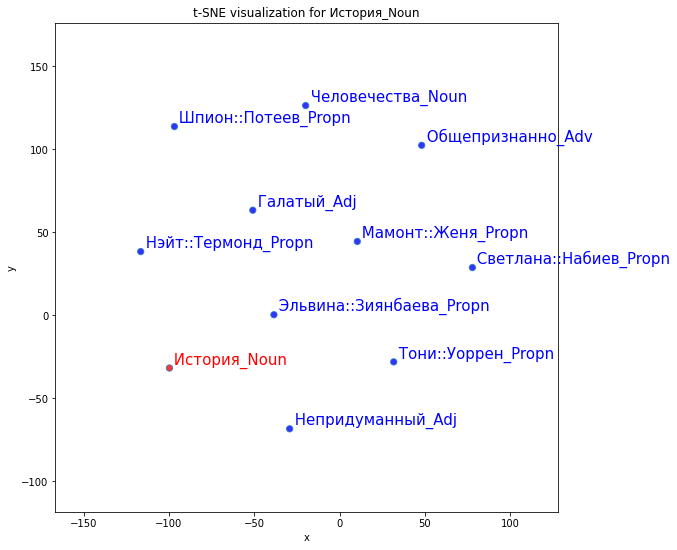

In [ ]:
tsne_scatterplot(embeddings, "история", top_words1)

# FastText

https://www.kaggle.com/code/hongpeiyi/text-classification-with-fasttext
https://colab.research.google.com/github/PragmaticsLab/NLP-course-FinTech/blob/master/seminars/2/2_embeddings.ipynb#scrollTo=s-IW_cBDX-sp

https://rukshanjayasekara.wordpress.com/2022/05/13/text-classification-with-fasttext/
https://colab.research.google.com/github/NaiveNeuron/nlp-excercises/blob/master/tutorial2-fasttext/Text_Classification_fastText.ipynb
https://rukshanjayasekara.wordpress.com/2022/05/13/text-classification-with-fasttext/

In [ ]:
df

,text,TargetClass
0,Сегодня у нас проходит т.н. гайдаровский форум...,1
1,Сбер представил отчет по РСБУ. Вклады населени...,0
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0
4,"Коммерсант сегодня написал, что Керимов хочет ...",1
...,...,...
1460,Сбербанк отмечает улучшение ситуации с реструк...,0
1461,Правительство России распространило действие п...,1
1462,Совкомбанк занимает 8 место по активам среди р...,0
1463,Правительство принимает «некоторые меры» для п...,0


In [ ]:
df['TargetClass'].value_counts()

1    743
0    722
Name: TargetClass, dtype: int64

In [ ]:
# Lets do some cleaning of this text
def clean_it(text,normalize=True):
    # Replacing possible issues with data. We can add or reduce the replacemtent in this chain
    s = str(text).replace(',',' ').replace('"','').replace('\'',' \' ').replace('.',' . ').replace('(',' ( ').\
            replace(')',' ) ').replace('!',' ! ').replace('?',' ? ').replace(':',' ').replace(';',' ').lower()

    s = re.sub(r'http\S+', '', s)
    s = s.replace(u'\xa0', u' ')
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    s = regex.sub(' ', s)
    s = re.sub(r'\s+', ' ', s)

    # normalizing / encoding the text
    if normalize:
        s = s.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8')

    return s

# Now lets define a small function where we can use above cleaning on datasets
def clean_df(data, cleanit= False, shuffleit=False, encodeit=False, label_prefix='__class__'):
    # Defining the new data
    df = data.copy(deep=True)
    df['class'] = label_prefix + df['TargetClass'].astype(str) + ' '

    # cleaning it
    if cleanit:
        df['text'] = df['text'].apply(lambda x: clean_it(x,encodeit))
#         df['id'] = df['id'].apply(lambda x: clean_it(x,encodeit))

    # shuffling it
    if shuffleit:
        df.sample(frac=1).reset_index(drop=True)

    return df

In [ ]:
%%time
# Transform the datasets using the above clean functions
data_train_cleaned = clean_df(df, True, True)

CPU times: total: 297 ms
Wall time: 297 ms


In [ ]:
data_train_cleaned

,text,TargetClass,class
0,сегодня у нас проходит т н гайдаровский форум ...,1,__class__1
1,сбер представил отчет по рсбу вклады населения...,0,__class__0
2,мы будем предлагатьсказал улюкаев чтобы приват...,0,__class__0
3,здравствуйте сегодня наткнулся на ткую новость...,0,__class__0
4,коммерсант сегодня написал что керимов хочет о...,1,__class__1
...,...,...,...
1460,сбербанк отмечает улучшение ситуации с реструк...,0,__class__0
1461,правительство россии распространило действие п...,1,__class__1
1462,совкомбанк занимает 8 место по активам среди р...,0,__class__0
1463,правительство принимает «некоторые меры» для п...,0,__class__0


In [ ]:
data_train_cleaned = data_train_cleaned[['class', 'text']]
data_train_cleaned

,class,text
0,__class__1,сегодня у нас проходит т н гайдаровский форум ...
1,__class__0,сбер представил отчет по рсбу вклады населения...
2,__class__0,мы будем предлагатьсказал улюкаев чтобы приват...
3,__class__0,здравствуйте сегодня наткнулся на ткую новость...
4,__class__1,коммерсант сегодня написал что керимов хочет о...
...,...,...
1460,__class__0,сбербанк отмечает улучшение ситуации с реструк...
1461,__class__1,правительство россии распространило действие п...
1462,__class__0,совкомбанк занимает 8 место по активам среди р...
1463,__class__0,правительство принимает «некоторые меры» для п...


In [ ]:
X_train, X_test, y_train, y_test= train_test_split(data_train_cleaned.drop(['class'], axis=1), data_train_cleaned['class'], test_size = 0.2, random_state = 42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1172, 1), (293, 1), (1172,), (293,))

In [ ]:
train = pd.concat([y_train, X_train], axis = 1).reset_index(drop=True)
train

,class,text
0,__class__0,сбербанк не поддержал введение института небан...
1,__class__0,цб рф не исключает повышения прогноза по прибы...
2,__class__1,к середине дня индекс мосбиржи торговался вбли...
3,__class__0,сбер вывел на рынок собственную платформу по в...
4,__class__0,автокредиты в октябре оказались самым депресси...
...,...,...
1167,__class__0,контракт «газпрома» с украиной может развалить...
1168,__class__1,сервис доставки продуктов «сбермаркет» перерег...
1169,__class__0,банк втб отчитался близко к прогнозу прибыль с...
1170,__class__0,«банки вернулись в хорошую форму пора думать о...


In [ ]:
test = pd.concat([y_test, X_test], axis = 1).reset_index(drop=True)
test

,class,text
0,__class__1,втб управление инвестициями провела стратегиче...
1,__class__0,слабый рост чистых комиссий может быть компенс...
2,__class__0,«газпром» готов договариваться с «нафтогазом» ...
3,__class__1,в среду 31 июля сбербанк опубликует финансовые...
4,__class__1,выход глобальной экономики из «режима пандемии...
...,...,...
288,__class__0,прирост ипотечного портфеля в 2023г превысил 3...
289,__class__1,газообразные обещания почему новые предложения...
290,__class__0,мордашов заинтересовался покупкой доли в сети ...
291,__class__0,сбербанк планирует выкупить акции на сумму до ...


In [ ]:
# Write files to disk as fastText classifier API reads files from disk.
train_file =  'train.csv'
train.to_csv(train_file, header=None, index=False, columns=['class','text'] )
test_file =  'test.csv'
test.to_csv(test_file, header=None, index=False, columns=['class','text'] )

In [ ]:
"""fastText expects and training file (csv), a model name as input arguments.
label_prefix refers to the prefix before label string in the dataset.
default is __label__. In our dataset, it is __class__.
There are several other parameters which can be seen in:
https://pypi.org/project/fasttext/
"""
model7 = train_supervised(input=train_file, label="__class__", lr=1.0, epoch=100, loss='ova', wordNgrams=2, dim=200, thread=2, verbose=100)

In [ ]:
model7.get_word_vector("хорошо")

array([ 4.70277388e-03,  3.27658211e-03,  1.17006823e-02, -2.27539744e-02,
        1.12598483e-02,  4.20230860e-03, -5.16136969e-03, -2.78879814e-02,
       -1.00221112e-02, -1.08292338e-03, -2.40237340e-02, -1.25146555e-02,
        1.21126901e-02, -1.72178075e-03,  3.64310201e-03,  2.14757286e-02,
        8.23559985e-03,  1.31368851e-02,  3.49544175e-03, -3.95038724e-03,
        7.02214567e-03,  1.45433284e-02,  1.15804654e-03,  4.09877719e-03,
        1.24823889e-02, -5.03262272e-03, -1.48990517e-03,  2.06843503e-02,
        1.96168991e-03,  2.36591659e-02,  1.34989619e-02,  7.10282568e-03,
        2.11357642e-02,  3.23739164e-02,  2.06180867e-02,  2.83607375e-02,
       -1.24558702e-03,  1.17399124e-03,  7.74009712e-03, -8.87977052e-03,
       -5.15351351e-03, -2.37789974e-02,  1.88095524e-04, -9.80076657e-05,
        4.23183152e-03, -1.16634304e-02,  3.17366095e-04, -8.76651891e-03,
       -1.77645627e-02, -2.44533774e-02,  3.33432741e-02,  7.74826296e-03,
       -2.74966680e-03, -

In [ ]:
model7.get_nearest_neighbors('хорошо')

[(0.9767996072769165, 'обязательствам'),
 (0.9765377044677734, 'начинает'),
 (0.9764205813407898, 'компаниями'),
 (0.9763075113296509, 'сохраняет'),
 (0.9762691855430603, 'видит'),
 (0.9762370586395264, 'благодаря'),
 (0.9761258363723755, 'производству'),
 (0.9761194586753845, 'занять'),
 (0.9761006832122803, 'куда'),
 (0.9760592579841614, 'способны')]

In [ ]:
# проблема с опечатками решена
model7.get_nearest_neighbors('хоршо')

[(0.0, 'по'),
 (0.0, 'на'),
 (0.0, 'с'),
 (0.0, 'руб'),
 (0.0, 'за'),
 (0.0, 'млрд'),
 (0.0, 'не'),
 (0.0, 'амстердамский'),
 (0.0, 'зарегистрирован'),
 (0.0, 'амстердамским')]

In [ ]:
# проблема с out of vocabulary словами - тоже
model7.get_nearest_neighbors('moviegeek')

[(0.0, 'по'),
 (0.0, 'на'),
 (0.0, 'с'),
 (0.0, 'руб'),
 (0.0, 'за'),
 (0.0, 'млрд'),
 (0.0, 'не'),
 (0.0, 'амстердамский'),
 (0.0, 'зарегистрирован'),
 (0.0, 'амстердамским')]

In [ ]:
model7.get_analogies("женщина", "мужчина", "актер")

[(0.0, 'по'),
 (0.0, 'на'),
 (0.0, 'с'),
 (0.0, 'руб'),
 (0.0, 'за'),
 (0.0, 'млрд'),
 (0.0, 'не'),
 (0.0, 'амстердамский'),
 (0.0, 'зарегистрирован'),
 (0.0, 'амстердамским')]

In [ ]:
for k in range(1,6):
    results = model7.test(test_file,k=k)
    print(f"Test Samples: {results[0]} Precision@{k} : {results[1]*100:2.4f} Recall@{k} : {results[2]*100:2.4f}")

Test Samples: 293 Precision@1 : 54.9488 Recall@1 : 54.9488
Test Samples: 293 Precision@2 : 50.0000 Recall@2 : 100.0000
Test Samples: 293 Precision@3 : 50.0000 Recall@3 : 100.0000
Test Samples: 293 Precision@4 : 50.0000 Recall@4 : 100.0000
Test Samples: 293 Precision@5 : 50.0000 Recall@5 : 100.0000


In [ ]:
ress1 = []
for sentence in tqdm(df['text']):
    # print(sentence)
    res = {}
#     sentence = sentence.replace("\n"," ")
    res['text'] = sentence
    # print(res['text'])
    preds = model7.predict(sentence)[0]
    # print(preds)
    if preds[0] == '__class__1':
                  label = 1
    else:
                  label = 0
    res['pred_class'] = label
    ress1.append(res)

  0%|          | 0/1465 [00:00<?, ?it/s]

In [ ]:
itog1 = pd.DataFrame.from_dict(ress1)
itog1['class'] = df['TargetClass'].reset_index(drop=True)
itog1

,text,pred_class,class
0,Сегодня у нас проходит т.н. гайдаровский форум...,1,1
1,Сбер представил отчет по РСБУ. Вклады населени...,0,0
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0,0
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0,0
4,"Коммерсант сегодня написал, что Керимов хочет ...",1,1
...,...,...,...
1460,Сбербанк отмечает улучшение ситуации с реструк...,0,0
1461,Правительство России распространило действие п...,1,1
1462,Совкомбанк занимает 8 место по активам среди р...,0,0
1463,Правительство принимает «некоторые меры» для п...,0,0


In [ ]:
itog1.value_counts("pred_class")

pred_class
1    757
0    708
dtype: int64

In [ ]:
f1 = metrics.f1_score(itog1['class'], itog1['pred_class'])
acc = metrics.accuracy_score(itog1['class'], itog1['pred_class'])
recall = metrics.precision_score(itog1['class'], itog1['pred_class'])
print('f1: {:.4f}, acc: {:.4f}, recall: {:.4f}'.format(f1, acc, recall))

f1: 0.8893, acc: 0.8867, recall: 0.8811


# Clove

https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html
    
https://debuggercafe.com/pretrained-glove-embeddings/

# RNN

https://debuggercafe.com/text-classification-using-pytorch/
    
https://debuggercafe.com/text-classification-using-pytorch/
    
https://github.com/prakashpandey9/Text-Classification-Pytorch/tree/master
    
https://saturncloud.io/blog/pytorch-for-natural-language-processing-building-a-fake-news-classification-model/

In [5]:
# Set seed.
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [ ]:
!nvidia-smi

Thu Dec  7 13:37:50 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
df_rnn = pd.read_csv(f'{sym1}_dataset_news.csv')
df_rnn

,text,TargetClass
0,Сегодня у нас проходит т.н. гайдаровский форум...,1
1,Сбер представил отчет по РСБУ. Вклады населени...,0
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0
4,"Коммерсант сегодня написал, что Керимов хочет ...",1
...,...,...
1463,Правительство принимает «некоторые меры» для п...,0
1464,Российские банки выдадут ипотечных кредитов по...,0
1465,В России могут повысить первоначальный взнос п...,1
1466,«Объем выдач потребительских кредитов в четвер...,0


In [7]:
def clean_text(text):
    text = re.sub(r'http\S+', '', text)
    text = text.replace(u'\xa0', u' ')
    text = text.lower()
#     text = re.sub(r'[^\w\s]+|[\d]+', r'',text).strip()
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    text = regex.sub(' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = " ".join(word for word in text.split() if word not in STOPWORDS)
    # text = " ".join(lemmatizer.normal_forms(word)[0] for word in text.split())
    return text

df_rnn['clean_text'] = df_rnn['text'].apply(clean_text)
df_rnn.head()

,text,TargetClass,clean_text
0,Сегодня у нас проходит т.н. гайдаровский форум...,1,сегодня проходит т н гайдаровский форум делают...
1,Сбер представил отчет по РСБУ. Вклады населени...,0,сбер представил отчет рсбу вклады населения 27...
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0,будем предлагатьсказал улюкаев приватизировать...
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0,здравствуйте сегодня наткнулся ткую новость бу...
4,"Коммерсант сегодня написал, что Керимов хочет ...",1,коммерсант сегодня написал керимов хочет обкеш...


In [8]:
df_rnn['text'].loc[100]

'ВИРТУАЛЬНЫЙ ОПЕРАТОР СВЯЗИ СБЕРБАНКА НАЧНЕТ РАБОТУ ДО КОНЦА ЭТОГО ГОДАСбербанк планирует развивать услуги виртуального оператора связи (MNVO), используя инфраструктуру Tele2. Партнеры рассчитывают запустить пилотный проект в одном из регионов в ближайшем будущем, а затем развивать его в 65 регионах присутствия Tele2.Сбербанк еще официально не представил оператора MVNO. Проект позволит банку снизить операционные затраты, связанные с услугами связи, и более активно продвигать мобильные финансовые технологии. В настоящий момент нам сложно оценить, как проект повлияет на финансовые показатели Сбербанка, однако ранее банк заявлял, что только на рассылку СМС клиентам банк тратит $100 млн в год. \xa0\xa0 \xa0 \xa0 \xa0 \xa0 \xa0 \xa0 АТОН'

In [9]:
df_rnn['clean_text'].loc[100]

'виртуальный оператор связи сбербанка начнет работу конца годасбербанк планирует развивать услуги виртуального оператора связи mnvo используя инфраструктуру tele2 партнеры рассчитывают запустить пилотный проект одном регионов ближайшем будущем затем развивать 65 регионах присутствия tele2 сбербанк официально представил оператора mvno проект позволит банку снизить операционные затраты связанные услугами связи активно продвигать мобильные финансовые технологии настоящий момент нам сложно оценить проект повлияет финансовые показатели сбербанка однако ранее банк заявлял рассылку смс клиентам банк тратит 100 млн год атон'

In [10]:
def find_longest_length(data):
    """
    Find the longest review length in the entire training set.

    :param data.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for text in data['clean_text']:
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            if len(corpus) > max_length:
                max_length = len(corpus)
    return max_length

longest = find_longest_length(df_rnn)
print(f"Longest review length: {longest} words")

Longest review length: 1159 words


In [11]:
def find_longest_length(data):
    """
    Find the longest review length in the entire training set.

    :param data.

    Returns:
        max_len: Longest review length.
    """
    max_length = 0
    for text in data['text']:
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            if len(corpus) > max_length:
                max_length = len(corpus)
    return max_length

longest = find_longest_length(df_rnn)
print(f"Longest review length: {longest} words")

Longest review length: 1435 words


In [12]:
def find_avg_sentence_length(data):
    """
    Find the average sentence in the entire training set.

    :param data['text'].

    Returns:
        avg_len: Average length.
    """
    sentence_lengths = []
    for text in data['clean_text']:
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            sentence_lengths.append(len(corpus))
    return sum(sentence_lengths)/len(sentence_lengths)

average_length = find_avg_sentence_length(df_rnn)
print(f"Average review length train: {average_length} words")

Average review length train: 217.5040871934605 words


In [13]:
def find_avg_sentence_length(data):
    """
    Find the average sentence in the entire training set.

    :param data['text'].

    Returns:
        avg_len: Average length.
    """
    sentence_lengths = []
    for text in data['text']:
            # Remove <br> tags.
            text = re.sub('<[^>]+>+', '', text)
            corpus = [
                word for word in text.split()
            ]
            sentence_lengths.append(len(corpus))
    return sum(sentence_lengths)/len(sentence_lengths)

average_length = find_avg_sentence_length(df_rnn)
print(f"Average review length train: {average_length} words")

Average review length train: 269.47615803814716 words


In [14]:
class DatasetSeq(Dataset):
    def __init__(self, df):
        #open file
        self.train = df
#         self.train = pd.read_csv('SBERP_dataset_news.csv')
        # delete extra tag markup
        train1 = [x for x in self.train['clean_text']]

        #init vocabs of tokens for encoding { token:  id}
        self.word_vocab = {} # {cat: 1, sat: 2, on: 3, mat: 4, '.': 5}
        self.char_vocab = {} # {c: 1, a: 2, t: 3, ' ': 4, s: 5}

        # Cat sat on mat. -> [1, 2, 3, 4, 5]
        # p    a  r  p pu -> [1, 2, 3, 1, 4]
        # chars  -> [1, 2, 3, 4, 5, 2, 3, 4]

        #init encoded sequences lists (processed data)
        self.encoded_sequences = []
        self.encoded_char_sequences = []

        # n=1 because first (n=0) value is padding
        n_word = 1
        n_char = 1

        for line in train1:
            sequence = []
            chars = []

            for word in line.split(' '):
                if word != '':

                        if self.word_vocab.get(word) is None:
                                    self.word_vocab[word] = n_word
                                    n_word += 1

                        for char in word:
                                    if self.char_vocab.get(char) is None:
                                                self.char_vocab[char] = n_char
                                                n_char += 1

                        sequence.append(self.word_vocab[word])
                        chars.append([self.char_vocab[char] for char in word])

            self.encoded_sequences.append(sequence)
            self.encoded_char_sequences.append(chars)

    def __len__(self):
        return len(self.encoded_sequences)

    def __getitem__(self, index):
        return {
            'data': self.encoded_sequences[index], # [1, 2, 3, 4, 6] len=5
            'char': self.encoded_char_sequences[index],# [[1,2,3], [4,5], [1,2], [2,6,5,4], []] len=5
            'target': self.train['TargetClass'].loc[index], #  (1)
        }

In [15]:
dataset = DatasetSeq(df_rnn)

In [16]:
dataset.__len__()

1468

In [17]:
dataset.__getitem__(1)

{'data': [39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  48,
  53,
  54,
  49,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  53,
  62,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  21,
  75,
  76,
  77,
  78,
  56,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  23,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  91,
  97,
  98,
  21,
  57,
  99,
  100,
  101,
  102,
  61,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  80,
  81,
  112,
  113,
  114],
 'char': [[1, 30, 2, 9],
  [8, 9, 2, 5, 1, 12, 13, 15, 11, 20],
  [4, 12, 23, 2, 12],
  [9, 1, 30, 18],
  [15, 16, 20, 13, 5, 24],
  [6, 13, 1, 2, 20, 2, 6, 11, 7],
  [32, 37],
  [38],
  [34, 33],
  [39],
  [12, 9, 20, 6],
  [9, 18, 30, 15, 16, 20, 13, 5, 24],
  [21, 9, 20, 11, 28],
  [40, 32],
  [39],
  [35],
  [37],
  [12, 9, 20, 6],
  [9, 18, 30, 23, 11, 1, 12, 13, 7],
  [8, 9, 11, 30, 24, 20, 27],
  [32, 33, 34, 38],
  [18, 8, 13, 20,

In [18]:
def collate_fn(input_data):

    data = []
    chars = []
    targets = []
    max_len = 0

    for item in input_data:
        if len(item['data']) > max_len:
            max_len = len(item['data'])
        data.append(torch.as_tensor(item['data']))
        chars.append(item['char'])
        targets.append(torch.as_tensor(item['target']))

    chars_seq = [[torch.as_tensor([0]) for _ in range(len(input_data))] for _ in range(max_len)]

    for j in range(len(input_data)):
        for i in range(max_len):
            if len(chars[j]) > i:
                chars_seq[i][j] = torch.as_tensor(chars[j][i])

    for j in range(max_len):
        chars_seq[j] = pad_sequence(chars_seq[j], batch_first=True, padding_value=0)

    data = pad_sequence(data, batch_first=True, padding_value=0)
    targets = torch.tensor(targets, dtype=torch.float32)

    return {'data': data, 'chars': chars_seq, 'target': targets}

In [19]:
#hyper params
vocab_size = len(dataset.word_vocab) + 1
n_classes = 1
n_chars = len(dataset.char_vocab) + 1
#TODO try to use other model parameters
emb_dim = 256 # поменял с 256 на 128
hidden = 256
char_hid = 64
char_emb = 32
n_epochs = 10
batch_size = 16
cuda_device = 0
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'
print(device)

cuda:0


In [20]:
train_size = int(0.9 * len(dataset))
size = len(dataset) - train_size
val_size = int(0.5 * size)
test_size = size - val_size
# train_size, val_size, test_size, len(dataset), train_size + val_size + test_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

In [21]:
len(train_dataset), len(val_dataset), len(test_dataset)

(1321, 73, 74)

In [22]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, collate_fn=collate_fn, drop_last = True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True, collate_fn=collate_fn, drop_last = True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=True, collate_fn=collate_fn, drop_last = True)

In [ ]:
class CharRNN_GRU(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim):
        super().__init__()
        self.char_emb = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        emb = self.char_emb(x) # B x T x Emb_dim
        _, out = self.rnn(emb)
        # _: B x T x Hidden
        # out: 1 x B x Hidden

        return out.transpose(0, 1) # B x 1 x Hidden

In [ ]:
class RNN_GRU_CH(nn.Module):

    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes,
                 char_vocab, char_emb, char_hidden):
        super().__init__()
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # batch_first = False: T x B x Vec
        # batch_first = True: B x T x Vec
        self.rnn = nn.GRU(emb_dim + char_hidden, hidden_dim, num_layers=1, batch_first=True, bidirectional=False)
        self.clf = nn.Linear(hidden_dim, n_classes)
        self.do = nn.Dropout(0.2)
        self.hidden_dim = hidden_dim
        self.char_rnn = CharRNN_GRU(char_vocab, char_emb, char_hidden)

    def forward(self, x, chars):
        emb = self.word_emb(x)
        char_features = [self.char_rnn(c.to(x.device)) for c in chars]
        char_features = torch.cat(char_features, dim=1) # конкатенация по времени B x T x Char_hid
        emb = torch.cat((emb, char_features), dim=-1) # конкатенация векторов
        output, context = self.rnn(emb)

        out = self.clf(self.do(context))

        return out.view(-1)

In [ ]:
model = RNN_GRU_CH(vocab_size, emb_dim, hidden, n_classes, n_chars, char_emb, char_hid).to(device)
print(model)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001,)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

RNN_GRU_CH(
  (word_emb): Embedding(44016, 256)
  (rnn): GRU(320, 256, batch_first=True)
  (clf): Linear(in_features=256, out_features=1, bias=True)
  (do): Dropout(p=0.2, inplace=False)
  (char_rnn): CharRNN_GRU(
    (char_emb): Embedding(105, 32)
    (rnn): GRU(32, 64, batch_first=True)
  )
)
11,734,433 total parameters.
11,734,433 training parameters.



In [ ]:
batch = next(iter(train_dataloader))
# batch['data'].shape, len(batch['chars']), batch['target'].shape
predict = model(batch['data'].to(device), batch['chars'])
predict.shape, batch['target'].shape

(torch.Size([16]), torch.Size([16]))

In [ ]:
def binary_accuracy(labels, outputs, train_running_correct):
    # As the outputs are currently logits.
    outputs = torch.sigmoid(outputs)
    # print(outputs)
    # print(labels)
    running_correct = 0
    for i, label in enumerate(labels):
        if label < 0.5 and outputs[i] < 0.5:
            running_correct += 1
        elif label >= 0.5 and outputs[i] >= 0.5:
            running_correct += 1
    return running_correct

In [ ]:
binary_accuracy(batch['target'], predict, 0)

7

In [ ]:
# Training function.
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    clip = 5
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        inputs, chars, labels = data['data'], data['chars'], data['target']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(inputs, chars)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        running_correct = binary_accuracy(
            labels, outputs, train_running_correct
        )
        train_running_correct += running_correct
        # Backpropagation.
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Update the optimizer parameters.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# Validation function.
def validate(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            inputs, chars, labels = data['data'], data['chars'], data['target']
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(inputs, chars)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            running_correct = binary_accuracy(
                labels, outputs, valid_running_correct
            )
            valid_running_correct += running_correct

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
epochs = n_epochs
# Lists to keep track of losses and accuracies.
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []
valid_loss_min = np.Inf
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader,
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(model, val_dataloader,
                                                criterion, device)
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}")
    # Save model.
    # if valid_epoch_loss <= valid_loss_min:
    torch.save(model, f'model_e{epoch}.pth')
        # valid_loss_min = valid_epoch_loss


    print('-'*50)

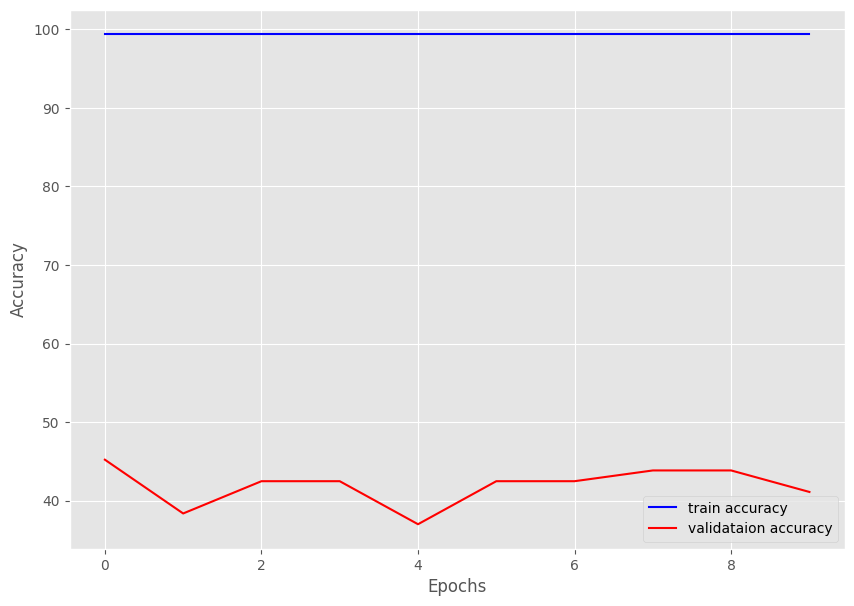

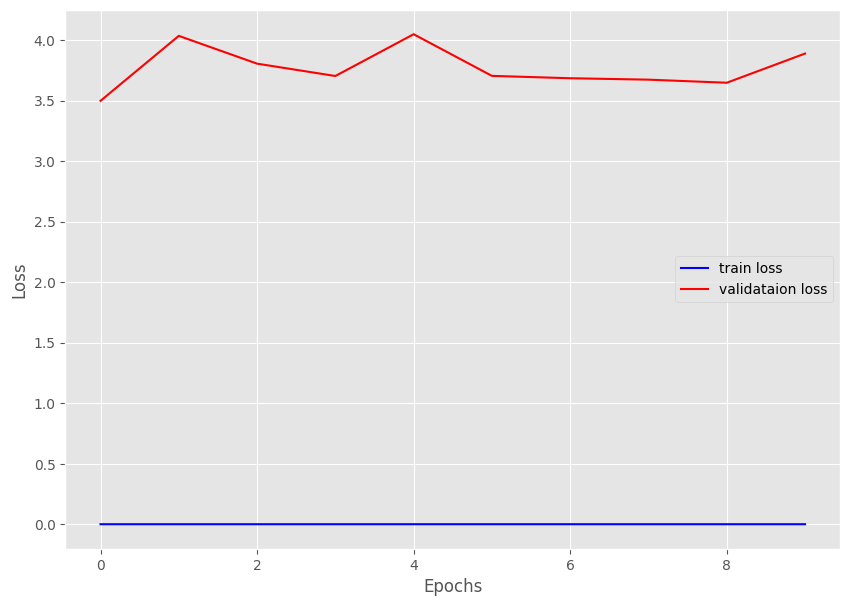

In [ ]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # Accuracy plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='blue', linestyle='-',
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='red', linestyle='-',
        label='validataion accuracy'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    # Loss plots.
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='blue', linestyle='-',
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-',
        label='validataion loss'
    )
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

save_plots(train_acc, valid_acc, train_loss, valid_loss)

In [ ]:
test_model = torch.load('model_e7.pth')

In [ ]:
test_running_correct = 0
counter = 0
model.eval()
with torch.no_grad():
     for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            counter += 1
            inputs, chars, labels = data['data'], data['chars'], data['target']
            inputs = inputs.to(device)
            outputs = test_model(inputs, chars)
            running_correct = binary_accuracy(
                labels, outputs, test_running_correct
            )
            test_running_correct += running_correct
test_acc = 100. * (test_running_correct / len(test_dataloader.dataset))
print(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

36.486486486486484


In [ ]:
class RNN_GRU(nn.Module):

    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes):
        super().__init__()
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # batch_first = False: T x B x Vec
        # batch_first = True: B x T x Vec
        self.rnn = nn.GRU(emb_dim, hidden_dim, num_layers=1, batch_first=True, bidirectional=False)
        self.clf = nn.Linear(hidden_dim, n_classes)
        self.do = nn.Dropout(0.2)
        self.hidden_dim = hidden_dim

    def forward(self, x):
        emb = self.word_emb(x)
        output, context = self.rnn(emb)

        out = self.clf(self.do(context))

        return out.view(-1)

In [ ]:
model1 = RNN_GRU(vocab_size, emb_dim, hidden, n_classes).to(device)
print(model1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model1.parameters(), lr=0.001,)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model1.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

RNN_GRU(
  (word_emb): Embedding(44016, 256)
  (rnn): GRU(256, 256, batch_first=True)
  (clf): Linear(in_features=256, out_features=1, bias=True)
  (do): Dropout(p=0.2, inplace=False)
)
11,663,105 total parameters.
11,663,105 training parameters.



In [ ]:
batch = next(iter(train_dataloader))
# batch['data'].shape, len(batch['chars']), batch['target'].shape
predict = model1(batch['data'].to(device))
predict.shape, batch['target'].shape

(torch.Size([16]), torch.Size([16]))

In [ ]:
def train1(model, trainloader, optimizer, criterion, device):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    clip = 5
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        inputs, chars, labels = data['data'], data['chars'], data['target']
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(inputs)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        running_correct = binary_accuracy(
            labels, outputs, train_running_correct
        )
        train_running_correct += running_correct
        # Backpropagation.
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Update the optimizer parameters.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
# Validation function.
def validate1(model, testloader, criterion, device):
    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0

    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            inputs, chars, labels = data['data'], data['chars'], data['target']
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(inputs)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            running_correct = binary_accuracy(
                labels, outputs, valid_running_correct
            )
            valid_running_correct += running_correct

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [ ]:
epochs = n_epochs
# Lists to keep track of losses and accuracies.
train_loss1, valid_loss1 = [], []
train_acc1, valid_acc1 = [], []
valid_loss_min = np.Inf
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train1(model1, train_dataloader,
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate1(model1, val_dataloader,
                                                criterion, device)
    train_loss1.append(train_epoch_loss)
    valid_loss1.append(valid_epoch_loss)
    train_acc1.append(train_epoch_acc)
    valid_acc1.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}")
    # Save model.
    # if valid_epoch_loss <= valid_loss_min:
    torch.save(model1, f'model1_e{epoch}.pth')
        # valid_loss_min = valid_epoch_loss

    print('-'*50)

[INFO]: Epoch 1 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.7140355684408327, training acc: 50.378787878787875
Validation loss: 0.692945808172226, validation acc: 46.57534246575342
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.6956130157156688, training acc: 51.36363636363637
Validation loss: 0.6869017481803894, validation acc: 43.83561643835616
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.6880569850526205, training acc: 53.86363636363637
Validation loss: 0.7006438076496124, validation acc: 41.0958904109589
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.6749532215478944, training acc: 53.63636363636364
Validation loss: 0.7144906222820282, validation acc: 38.35616438356164
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.6204678619780192, training acc: 66.5909090909091
Validation loss: 0.7404858469963074, validation acc: 46.57534246575342
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.41206859379279903, training acc: 83.56060606060606
Validation loss: 1.0307618081569672, validation acc: 38.35616438356164
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.18941731328462683, training acc: 93.18181818181817
Validation loss: 1.3915672600269318, validation acc: 41.0958904109589
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.07910787025693714, training acc: 97.5
Validation loss: 1.5388832092285156, validation acc: 36.986301369863014
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.040090281930865675, training acc: 98.48484848484848
Validation loss: 2.1728118658065796, validation acc: 41.0958904109589
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.022177207919700844, training acc: 98.86363636363636
Validation loss: 2.0208121240139008, validation acc: 41.0958904109589
--------------------------------------------------


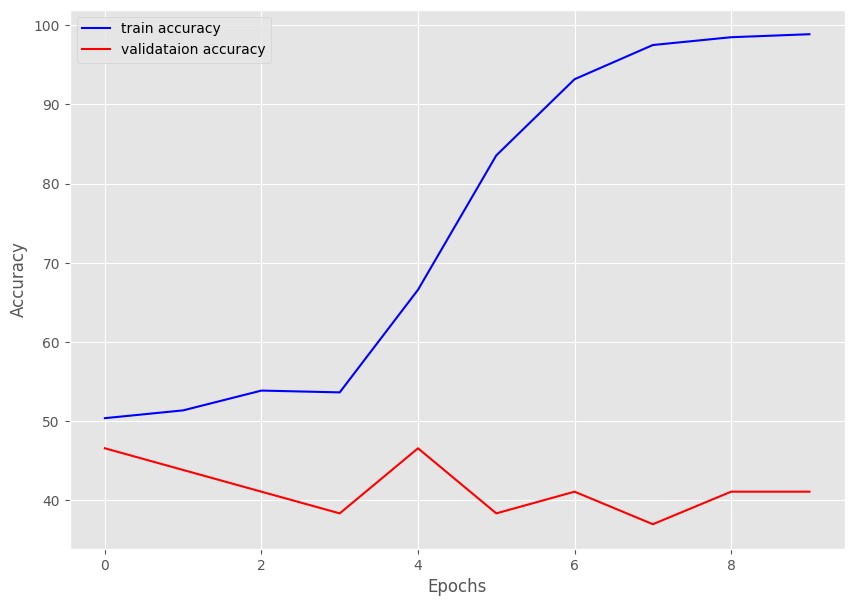

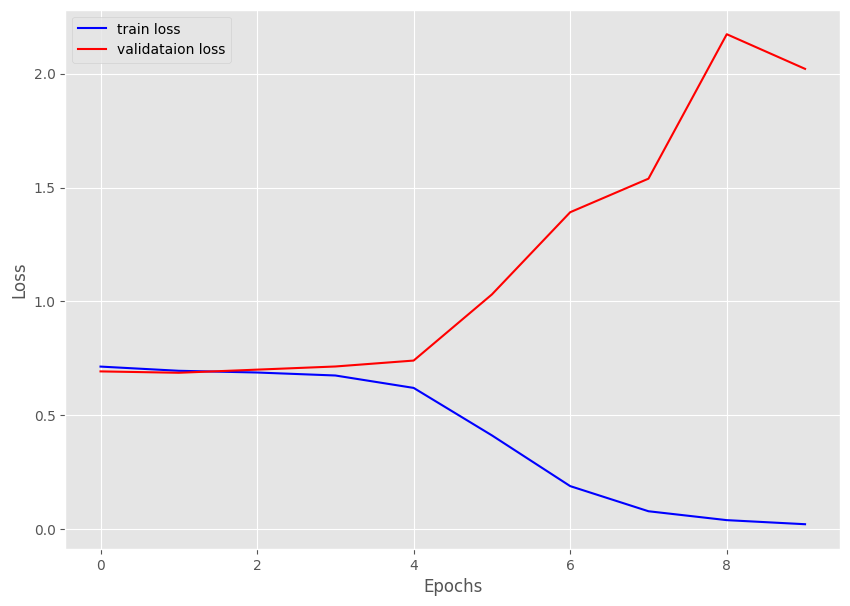

In [ ]:
save_plots(train_acc1, valid_acc1, train_loss1, valid_loss1)

In [ ]:
test_model1 = torch.load('model1_e5.pth')

In [ ]:
test_running_correct = 0
counter = 0
model.eval()
with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            counter += 1
            inputs, chars, labels = data['data'], data['chars'], data['target']
            inputs = inputs.to(device)
            outputs = test_model1(inputs)
            running_correct = binary_accuracy(
                labels, outputs, test_running_correct
            )
            test_running_correct += running_correct
test_acc = 100. * (test_running_correct / len(test_dataloader.dataset))
print(test_acc)

  0%|          | 0/4 [00:00<?, ?it/s]

55.4054054054054


# Attention

In [ ]:
class Attention_net(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, q, k, v):

        attn = torch.bmm(q, # B x T1 x V
                         k.transpose(1, 2), # B x T2 x V -> B x V x T2
                         ) # B x T1 x T2

        attn = self.softmax(attn)

        attn = self.dropout(attn)

        output = torch.bmm(attn, v) # B x T1 x T2 @ B x T1 x V

        return output

In [ ]:
class RNN_GRU_CH_Attention(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes,
                 char_vocab, char_emb, char_hidden):
        super().__init__()
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # batch_first = False: T x B x Vec
        # batch_first = True: B x T x Vec
        self.rnn = nn.GRU(emb_dim + char_hidden, hidden_dim, batch_first=True)
        self.clf = nn.Linear(hidden_dim*2, n_classes)
        self.do = nn.Dropout(0.2)
        self.hidden_dim = hidden_dim
        self.char_rnn = CharRNN_GRU(char_vocab, char_emb, char_hidden)
        self.attn = Attention_net()


    def forward(self, x, chars):

        emb = self.word_emb(x)
        char_features = [self.char_rnn(c.to(x.device)) for c in chars]
        char_features = torch.cat(char_features, dim=1) # конкатенация по времени B x T x Char_hid
        emb = torch.cat((emb, char_features), dim=-1) # конкатенация векторов

        output, context = self.rnn(emb)
        context = context.permute(1, 0, 2)
        attn_output = self.attn(context, output, output)
        out = self.do(torch.cat((context, attn_output), dim=-1))
        out = self.clf(out)

        return out.view(-1)

In [ ]:
model_a = RNN_GRU_CH_Attention(vocab_size, emb_dim, hidden, n_classes, n_chars, char_emb, char_hid).to(device)
print(model_a)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_a.parameters(), lr=0.001,)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_a.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model_a.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

RNN_GRU_CH_Attention(
  (word_emb): Embedding(44016, 256)
  (rnn): GRU(320, 256, batch_first=True)
  (clf): Linear(in_features=512, out_features=1, bias=True)
  (do): Dropout(p=0.2, inplace=False)
  (char_rnn): CharRNN_GRU(
    (char_emb): Embedding(105, 32)
    (rnn): GRU(32, 64, batch_first=True)
  )
  (attn): Attention_net(
    (dropout): Dropout(p=0.1, inplace=False)
    (softmax): Softmax(dim=2)
  )
)
11,734,689 total parameters.
11,734,689 training parameters.



In [ ]:
batch = next(iter(train_dataloader))
# batch['data'].shape, len(batch['chars']), batch['target'].shape
predict = model_a(batch['data'].to(device), batch['chars'])
loss = criterion(predict, batch['target'].to(device))
# predict.shape, batch['target'].shape
loss

tensor(0.6425, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)

In [ ]:
epochs = n_epochs
# Lists to keep track of losses and accuracies.
train_loss2, valid_loss2 = [], []
train_acc2, valid_acc2 = [], []
valid_loss_min2 = np.Inf
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train(model_a, train_dataloader,
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate(model_a, val_dataloader,
                                                criterion, device)
    train_loss2.append(train_epoch_loss)
    valid_loss2.append(valid_epoch_loss)
    train_acc2.append(train_epoch_acc)
    valid_acc2.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}")
    # Save model.
    # if valid_epoch_loss <= valid_loss_min2:
    torch.save(model_a, f'model_a_e{epoch}.pth')
        # valid_loss_min2 = valid_epoch_loss



    print('-'*50)

[INFO]: Epoch 1 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.7323032174168563, training acc: 49.848484848484844
Validation loss: 0.6894388794898987, validation acc: 46.57534246575342
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.6975672194143621, training acc: 50.15151515151515
Validation loss: 0.7017212212085724, validation acc: 42.465753424657535
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.697891017285789, training acc: 52.196969696969695
Validation loss: 0.7201813757419586, validation acc: 45.20547945205479
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.6496379826127029, training acc: 60.0
Validation loss: 0.7147247046232224, validation acc: 47.94520547945205
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.43171699526833324, training acc: 83.56060606060606
Validation loss: 0.8740040957927704, validation acc: 45.20547945205479
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.19231978458602253, training acc: 93.4090909090909
Validation loss: 1.3929965943098068, validation acc: 47.94520547945205
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.06814633473390486, training acc: 97.5
Validation loss: 1.4857271015644073, validation acc: 47.94520547945205
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.03184382334669552, training acc: 98.4090909090909
Validation loss: 1.9874381721019745, validation acc: 46.57534246575342
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.03250477544213759, training acc: 98.63636363636363
Validation loss: 1.9328783452510834, validation acc: 47.94520547945205
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.011533955951141784, training acc: 99.0909090909091
Validation loss: 1.9315763711929321, validation acc: 50.68493150684932
--------------------------------------------------


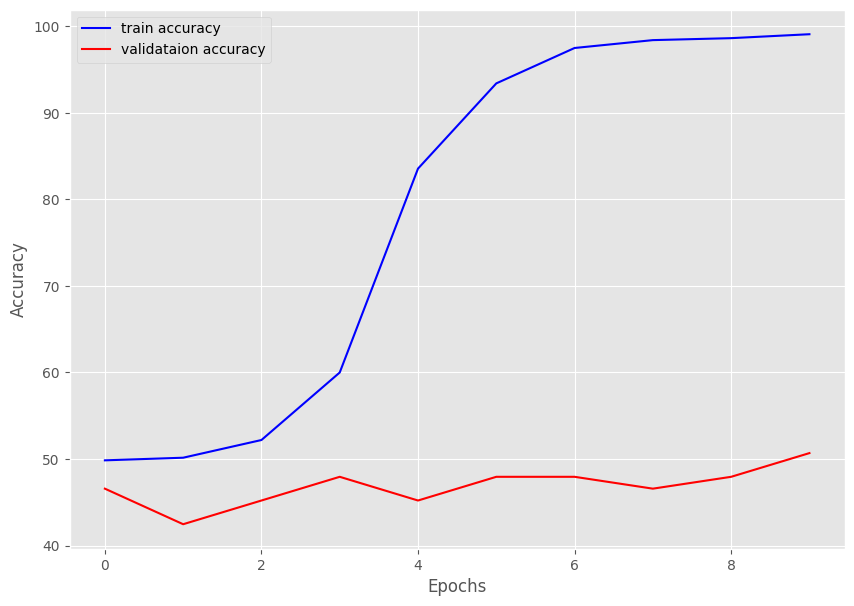

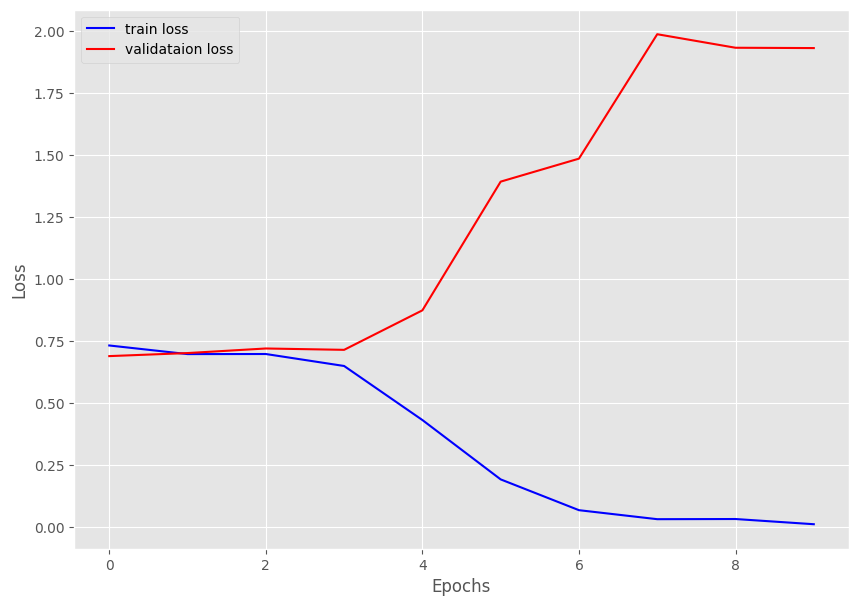

In [ ]:
save_plots(train_acc2, valid_acc2, train_loss2, valid_loss2)

In [ ]:
test_model_a = torch.load('model_a_e4.pth')

In [ ]:
test_running_correct = 0
counter = 0
model_a.eval()
with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            counter += 1
            inputs, chars, labels = data['data'], data['chars'], data['target']
            inputs = inputs.to(device)
            outputs = test_model_a(inputs, chars)
            running_correct = binary_accuracy(
                labels, outputs, test_running_correct
            )
            test_running_correct += running_correct
test_acc2 = 100. * (test_running_correct / len(test_dataloader.dataset))
print(test_acc2)

  0%|          | 0/4 [00:00<?, ?it/s]

43.24324324324324


In [ ]:
class RNN_GRU_CH_Attention(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, n_classes):
        super().__init__()
        #TODO try to use other RNN archicetures, f.e. RNN and LSTM
        self.word_emb = nn.Embedding(vocab_size, emb_dim)
        # batch_first = False: T x B x Vec
        # batch_first = True: B x T x Vec
        self.rnn = nn.GRU(emb_dim, hidden_dim, batch_first=True)
        self.clf = nn.Linear(hidden_dim*2, n_classes)
        self.do = nn.Dropout(0.2)
        self.hidden_dim = hidden_dim
        self.attn = Attention_net()


    def forward(self, x):

        emb = self.word_emb(x)
        output, context = self.rnn(emb)
        context = context.permute(1, 0, 2)
        attn_output = self.attn(context, output, output)
        out = self.do(torch.cat((context, attn_output), dim=-1))
        out = self.clf(out)

        return out.view(-1)

In [ ]:
model_a1 = RNN_GRU_CH_Attention(vocab_size, emb_dim, hidden, n_classes).to(device)
print(model_a1)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model_a1.parameters(), lr=0.001,)
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_a1.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in model_a1.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

RNN_GRU_CH_Attention(
  (word_emb): Embedding(44016, 256)
  (rnn): GRU(256, 256, batch_first=True)
  (clf): Linear(in_features=512, out_features=1, bias=True)
  (do): Dropout(p=0.2, inplace=False)
  (attn): Attention_net(
    (dropout): Dropout(p=0.1, inplace=False)
    (softmax): Softmax(dim=2)
  )
)
11,663,361 total parameters.
11,663,361 training parameters.



In [ ]:
batch = next(iter(train_dataloader))
# batch['data'].shape, len(batch['chars']), batch['target'].shape
predict = model_a1(batch['data'].to(device))
# loss = criterion(predict, batch['target'].to(device))
predict.shape, batch['target'].shape
# loss

(torch.Size([16]), torch.Size([16]))

In [ ]:
epochs = n_epochs
# Lists to keep track of losses and accuracies.
train_loss22, valid_loss22 = [], []
train_acc22, valid_acc22 = [], []
valid_loss_min22 = np.Inf
# Start the training.
for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_acc = train1(model_a1, train_dataloader,
                                            optimizer, criterion, device)
    valid_epoch_loss, valid_epoch_acc = validate1(model_a1, val_dataloader,
                                                criterion, device)
    train_loss22.append(train_epoch_loss)
    valid_loss22.append(valid_epoch_loss)
    train_acc22.append(train_epoch_acc)
    valid_acc22.append(valid_epoch_acc)
    print(f"Training loss: {train_epoch_loss}, training acc: {train_epoch_acc}")
    print(f"Validation loss: {valid_epoch_loss}, validation acc: {valid_epoch_acc}")
    # Save model.
    # if valid_epoch_loss <= valid_loss_min2:
    torch.save(model_a1, f'model_a1_e{epoch}.pth')
        # valid_loss_min2 = valid_epoch_loss



    print('-'*50)

[INFO]: Epoch 1 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.7218299137382973, training acc: 50.378787878787875
Validation loss: 0.6958159655332565, validation acc: 47.94520547945205
--------------------------------------------------
[INFO]: Epoch 2 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.7018537405060559, training acc: 52.42424242424243
Validation loss: 0.7010627388954163, validation acc: 43.83561643835616
--------------------------------------------------
[INFO]: Epoch 3 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.6935151270249995, training acc: 52.04545454545455
Validation loss: 0.6926342844963074, validation acc: 45.20547945205479
--------------------------------------------------
[INFO]: Epoch 4 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.6511541619533445, training acc: 61.66666666666667
Validation loss: 0.7374815493822098, validation acc: 41.0958904109589
--------------------------------------------------
[INFO]: Epoch 5 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.4825821184530491, training acc: 79.6969696969697
Validation loss: 0.8039693385362625, validation acc: 46.57534246575342
--------------------------------------------------
[INFO]: Epoch 6 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.22858414571823144, training acc: 92.12121212121212
Validation loss: 1.3015746027231216, validation acc: 45.20547945205479
--------------------------------------------------
[INFO]: Epoch 7 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.1155010920426831, training acc: 96.13636363636363
Validation loss: 1.5167019963264465, validation acc: 46.57534246575342
--------------------------------------------------
[INFO]: Epoch 8 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.06128580446877494, training acc: 97.87878787878788
Validation loss: 1.6515195071697235, validation acc: 49.31506849315068
--------------------------------------------------
[INFO]: Epoch 9 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.038309044392052585, training acc: 98.4090909090909
Validation loss: 2.093859851360321, validation acc: 46.57534246575342
--------------------------------------------------
[INFO]: Epoch 10 of 10
Training


  0%|          | 0/82 [00:00<?, ?it/s]

Validation


  0%|          | 0/4 [00:00<?, ?it/s]

Training loss: 0.028888089145056722, training acc: 98.86363636363636
Validation loss: 2.388216882944107, validation acc: 41.0958904109589
--------------------------------------------------


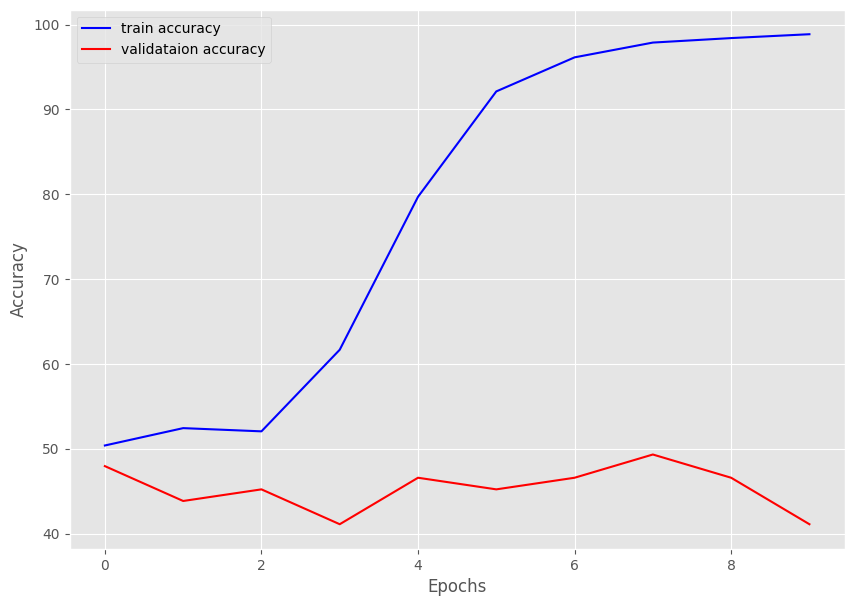

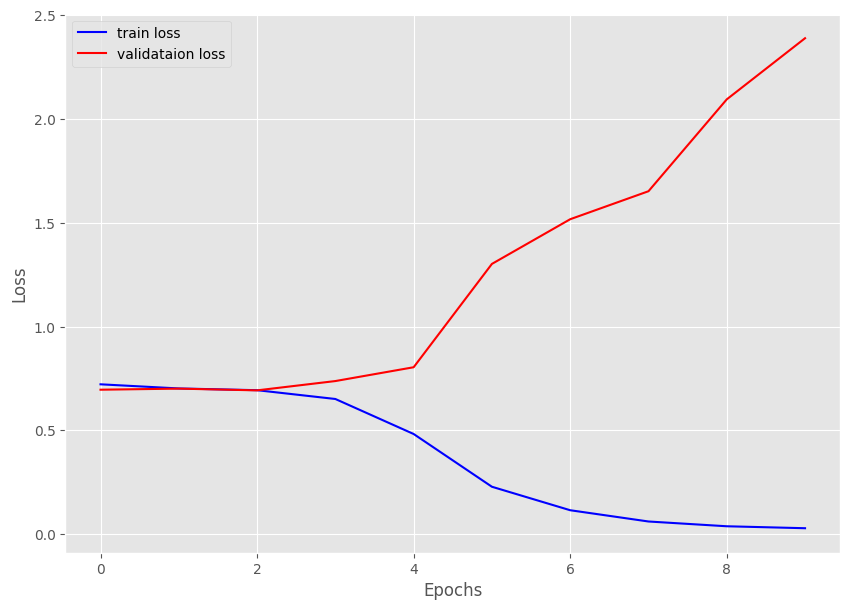

In [ ]:
save_plots(train_acc22, valid_acc22, train_loss22, valid_loss22)

In [ ]:
test_model_a1 = torch.load('model_a1_e5.pth')

In [ ]:
test_running_correct = 0
counter = 0
model_a1.eval()
with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
            counter += 1
            inputs, chars, labels = data['data'], data['chars'], data['target']
            inputs = inputs.to(device)
            outputs = test_model_a1(inputs)
            running_correct = binary_accuracy(
                labels, outputs, test_running_correct
            )
            test_running_correct += running_correct
test_acc22 = 100. * (test_running_correct / len(test_dataloader.dataset))
print(test_acc22)

  0%|          | 0/4 [00:00<?, ?it/s]

# Bert

In [ ]:
# https://saturncloud.io/blog/pytorch-for-natural-language-processing-building-a-fake-news-classification-model/
# https://valueml.com/sentiment-analysis-using-bert-in-python/
# https://skine.ru/articles/584642/

In [42]:
# Sentiment Analysis using BERT in Python
# https://valueml.com/sentiment-analysis-using-bert-in-python/

In [23]:
df_bert = df_rnn[['clean_text', 'TargetClass']].copy()
df_bert

,clean_text,TargetClass
0,сегодня проходит т н гайдаровский форум делают...,1
1,сбер представил отчет рсбу вклады населения 27...,0
2,будем предлагатьсказал улюкаев приватизировать...,0
3,здравствуйте сегодня наткнулся ткую новость бу...,0
4,коммерсант сегодня написал керимов хочет обкеш...,1
...,...,...
1463,правительство принимает «некоторые меры» повыш...,0
1464,российские банки выдадут ипотечных кредитов ит...,0
1465,россии могут повысить первоначальный взнос льг...,1
1466,«объем выдач потребительских кредитов четверто...,0


In [ ]:
# Splits data into features and target
X = df_bert['clean_text']
y = df_bert['TargetClass']

# Splits data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# Loads the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(X_train.values,
                                                add_special_tokens=True,
                                                return_attention_mask=True,
                                                pad_to_max_length=True,
                                                max_length=256,
                                                 return_tensors='pt'
                                                )
encoded_data_val = tokenizer.batch_encode_plus(X_test.values,
                                                add_special_tokens=True,
                                                return_attention_mask=True,
                                                pad_to_max_length=True,
                                                max_length=256,
                                                 return_tensors='pt'
                                                )

In [ ]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test.values)

In [ ]:
train_inputs = torch.tensor(encoded_data_train['input_ids']).to(device)
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

In [ ]:
dataset_train = TensorDataset(train_inputs, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
#SETTING MODEL
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2, output_attentions=False, output_hidden_states=False )

#CREATING DATA LOADERS
dataloader_train = DataLoader(dataset_train,sampler = RandomSampler(dataset_train), batch_size= 32)


dataloader_val = DataLoader(dataset_val, sampler = RandomSampler(dataset_val), batch_size= 32)


#SETTING OPTIMIZERS

op = AdamW(model.parameters(),lr=1e-5,eps=1e-8)

epochs = 10

# scheduler = get_linear_schedule_with_warmup(op, num_warmup_steps=0, num_training_steps=len(dataloader_train)*epochs)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#FUNCTION TO CALCULATE F1 SCORE
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

#FUNCTION FOR CALCULATING ACCURACY PER CLASS
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v:k for k,v in label_dict.items()}

    preds_flat = np.argmax(preds,axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(label_dict_inverse[label])
        print("accuracy ", len(y_preds[y_preds==label])/len(y_true))

#FUNCTION FOR MODEL EVALUATION
def evaluate(dataloader_val):

    model.eval()

    loss_val_total = 0
    predictions, true_vals = [], []

    for batch in dataloader_val:

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)

    loss_val_avg = loss_val_total/len(dataloader_val)

    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)

    return loss_val_avg, predictions, true_vals

In [ ]:
 model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train,
                        desc ='Epoch {:1d}'.format(epoch),
                        leave=False,
                       disable=False
                       )
    for batch in progress_bar:
        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = { 'input_ids' : batch[0],
                 'attention_mask' : batch[1],
                 'labels' : batch[2]
                 }
        outputs = model(**inputs)


        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        op.step()
        # scheduler.step()

        progress_bar.set_postfix({'training_loss':'{:.3f}'.format(loss.item()/len(batch))})

    # THIS SECTION OF CODE IS JUST FOR PRINTING VALUES AFTER EACH EPOCH.
    torch.save(model.state_dict(), f'BERT_ft_epoch{epoch}.model')
    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 score (weighted): {val_f1}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.693355754727409
Validation loss: 0.6940170884132385
F1 score (weighted): 0.33731324305423105


Epoch 2:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.6997110375336238
Validation loss: 0.694819986820221
F1 score (weighted): 0.3146102477688323


Epoch 3:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.6967518698601496
Validation loss: 0.6961426734924316
F1 score (weighted): 0.4729128279467542


Epoch 4:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.6917766162327358
Validation loss: 0.6915478706359863
F1 score (weighted): 0.3989960656627323


Epoch 5:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 5
Training loss: 0.6856124926181066
Validation loss: 0.7021675109863281
F1 score (weighted): 0.5097856285371292


Epoch 6:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 6
Training loss: 0.6614853455906823
Validation loss: 0.7709914803504944
F1 score (weighted): 0.41917023734423514


Epoch 7:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.6044008675075713
Validation loss: 0.823355758190155
F1 score (weighted): 0.4553541110693495


Epoch 8:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.5746677603040423
Validation loss: 0.8128510475158691
F1 score (weighted): 0.4886081416693661


Epoch 9:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.4958486258983612
Validation loss: 1.0568426132202149
F1 score (weighted): 0.43524729239014953


Epoch 10:   0%|          | 0/42 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.41939535098416464
Validation loss: 1.0735452771186829
F1 score (weighted): 0.48241874527588813


In [ ]:
def predict(text):
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=256,
        return_tensors='pt'
    )

    out = {
          'text': text,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten()
      }

    input_ids = out["input_ids"].to(device)
    attention_mask = out["attention_mask"].to(device)
    model.eval()
    with torch.no_grad():
            outputs = model(
                input_ids=input_ids.unsqueeze(0),
                attention_mask=attention_mask.unsqueeze(0)
            )

    prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

    return prediction

In [ ]:
ress = []
for sentence in tqdm(df_rnn['clean_text']):
    # print(sentence)
    res = {}
    res['text'] = sentence
    preds = predict(sentence)
    res['class'] = preds
    ress.append(res)

  0%|          | 0/1467 [00:00<?, ?it/s]

In [ ]:
itog = pd.DataFrame.from_dict(ress)
itog

,text,class
0,сегодня проходит т н гайдаровский форум делают...,1
1,сбер представил отчет рсбу вклады населения 27...,0
2,будем предлагатьсказал улюкаев приватизировать...,0
3,здравствуйте сегодня наткнулся ткую новость бу...,0
4,коммерсант сегодня написал керимов хочет обкеш...,1
...,...,...
1462,совкомбанк занимает 8 место активам среди росс...,0
1463,правительство принимает «некоторые меры» повыш...,0
1464,российские банки выдадут ипотечных кредитов ит...,0
1465,россии могут повысить первоначальный взнос льг...,1


In [ ]:
itog.value_counts("class")

class
1    796
0    671
dtype: int64

In [ ]:
df_rnn['class'] = itog['class']
df_rnn

,text,TargetClass,clean_text,class
0,Сегодня у нас проходит т.н. гайдаровский форум...,1,сегодня проходит т н гайдаровский форум делают...,1
1,Сбер представил отчет по РСБУ. Вклады населени...,0,сбер представил отчет рсбу вклады населения 27...,0
2,Мы будем предлагатьсказал Улюкаев. Чтобы прив...,0,будем предлагатьсказал улюкаев приватизировать...,0
3,"Здравствуйте, сегодня наткнулся на ткую новост...",0,здравствуйте сегодня наткнулся ткую новость бу...,0
4,"Коммерсант сегодня написал, что Керимов хочет ...",1,коммерсант сегодня написал керимов хочет обкеш...,1
...,...,...,...,...
1462,Совкомбанк занимает 8 место по активам среди р...,0,совкомбанк занимает 8 место активам среди росс...,0
1463,Правительство принимает «некоторые меры» для п...,0,правительство принимает «некоторые меры» повыш...,0
1464,Российские банки выдадут ипотечных кредитов по...,0,российские банки выдадут ипотечных кредитов ит...,0
1465,В России могут повысить первоначальный взнос п...,1,россии могут повысить первоначальный взнос льг...,1


In [ ]:
f1_score(df_rnn['TargetClass'], df_rnn['class']), accuracy_score(df_rnn['TargetClass'], df_rnn['class'])

(0.8649350649350649, 0.858214042263122)

In [28]:
# Модель BERT
# https://saturncloud.io/blog/pytorch-for-natural-language-processing-building-a-fake-news-classification-model/

In [24]:
# Splits data into features and target
X = df_bert['clean_text']
y = df_bert['TargetClass']

# Splits data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [26]:
# Detect if we have a GPU available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loads the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Encodes the training and testing set
train_encodings = tokenizer(list(X_train), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True, max_length=128)

# Converts the encoded data into PyTorch tensors and move them to the GPU if available
train_inputs = torch.tensor(train_encodings['input_ids']).to(device)
train_masks = torch.tensor(train_encodings['attention_mask']).to(device)
train_labels = torch.tensor(y_train.values).to(device)

test_inputs = torch.tensor(test_encodings['input_ids']).to(device)
test_masks = torch.tensor(test_encodings['attention_mask']).to(device)
test_labels = torch.tensor(y_test.values).to(device)

# Creates PyTorch datasets and data loaders
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_loader = DataLoader(train_dataset, batch_size=8)

test_dataset = TensorDataset(test_inputs, test_masks, test_labels)
test_loader = DataLoader(test_dataset, batch_size=8)

# Loads the BERT model and move it to the GPU if available
model = BertForSequenceClassification.from_pretrained('bert-base-uncased').to(device)

# Defines the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)

# Best accuracy initialization
best_accuracy = 0.0

# Trains the model
model.train()
for epoch in range(10):
    running_loss = 0.0
    correct = 0
    total = 0

    for step, batch in enumerate(train_loader):
        # Move batch tensors to the same device as the model
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        # Clears the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

        # Retrieves the loss
        loss = outputs.loss

        # Backward pass for gradient calculation
        loss.backward()

        # Updates the weights
        optimizer.step()

        # Accumulates the running loss
        running_loss += loss.item()

        # Predicts labels and calculates the number of correct predictions
        _, predicted = torch.max(outputs.logits, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy and loss on the entire training set
    accuracy = correct / total
    average_loss = running_loss / len(train_loader)

    # If the current epoch's accuracy is best so far, save this model to disk
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        # torch.save(model.state_dict(), 'best_model.pt')
        torch.save(model, 'best_model.pt')

    print(f"Epoch {epoch+1}/{10} - Training Loss: {average_loss:.4f} - Training Accuracy: {accuracy:.4f}")


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10 - Training Loss: 0.7030 - Training Accuracy: 0.4958
Epoch 2/10 - Training Loss: 0.6983 - Training Accuracy: 0.5004
Epoch 3/10 - Training Loss: 0.6966 - Training Accuracy: 0.5102
Epoch 4/10 - Training Loss: 0.6956 - Training Accuracy: 0.5004
Epoch 5/10 - Training Loss: 0.6967 - Training Accuracy: 0.4815
Epoch 6/10 - Training Loss: 0.6953 - Training Accuracy: 0.5026
Epoch 7/10 - Training Loss: 0.6949 - Training Accuracy: 0.5125
Epoch 8/10 - Training Loss: 0.6942 - Training Accuracy: 0.5087
Epoch 9/10 - Training Loss: 0.6935 - Training Accuracy: 0.5223
Epoch 10/10 - Training Loss: 0.6956 - Training Accuracy: 0.5178


In [29]:
# Sets the model to evaluation mode
model.eval()

# Variables to gather full output
total_eval_accuracy = 0
total_eval_loss = 0
nb_eval_steps = 0

# Evaluate data for one epoch
for batch in test_loader:
    # Unpack this training batch from our dataloader and move tensors to GPU if available
    input_ids, attention_mask, labels = [b.to(device) for b in batch]

    # Tells PyTorch not to bother with constructing the compute graph during
    # the forward pass, since this is only needed for backprop (training)
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)

    # Get the loss and logits
    loss = outputs.loss
    logits = outputs.logits

    # Accumulate the validation loss
    total_eval_loss += loss.item()

    # Calculate the accuracy for this batch of test sentences, and accumulate it over all batches
    _, predictions = torch.max(logits, dim=1)
    total_eval_accuracy += (predictions == labels).sum().item()

# Report the final accuracy for this validation run
avg_val_accuracy = total_eval_accuracy / len(test_loader.dataset)
print("Accuracy on the test set: {0:.2f}".format(avg_val_accuracy))

# Calculate the average loss over all of the batches
avg_val_loss = total_eval_loss / len(test_loader)
print("Test Loss: {0:.2f}".format(avg_val_loss))

Accuracy on the test set: 0.47
Test Loss: 0.69


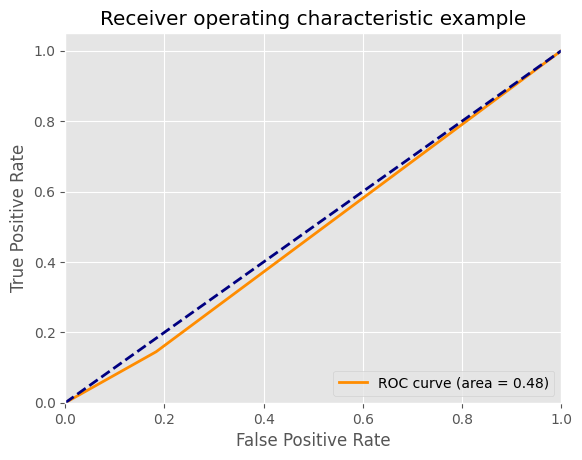

In [30]:
# Set the model to evaluation mode
model.eval()

# Lists to store actual and predicted values
true_labels = []
pred_labels = []

# Iterate over the test data and generate predictions
for batch in test_loader:
    input_ids, attention_mask, labels = [b.to(device) for b in batch]

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits
    logits = logits.detach().cpu().numpy()

    # Get the predictions and the true labels
    predictions = np.argmax(logits, axis=1)
    true_labels.extend(labels.tolist())
    pred_labels.extend(predictions.tolist())

# Compute ROC curve
fpr, tpr, _ = roc_curve(true_labels, pred_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2  # Line width
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [31]:
test_df = df_bert.sample(n = 100, random_state = 42) ## randomly creates samples from df_bert

In [35]:
def predict_articles(test_df: pd.DataFrame, model: BertForSequenceClassification, tokenizer: BertTokenizer):
    """
    Predicts whether each news article in a DataFrame is fake or real using a trained BERT model.

    Args:
        test_df (pd.DataFrame): The DataFrame containing the articles.
        model (BertForSequenceClassification): The trained BERT model.
        tokenizer (BertTokenizer): The BERT tokenizer.
    """

    # Ensure the model is in evaluation mode
    model.eval()

    # Iterate over each row in the DataFrame
    for i, row in test_df.iterrows():
        # Extract the article and true label
        article = row['clean_text']
        true_label = 'pos' if row['TargetClass'] == 1 else 'neg'

        # Encode the article text
        encoded_text = tokenizer.encode_plus(
            article,
            add_special_tokens=True,
            max_length=512,
            padding='max_length',
            truncation=True, # truncates the text to the specified max_length
            return_attention_mask=True,
            return_tensors='pt'
        )

        # Move tensors to the same device as the model
        input_ids = encoded_text['input_ids'].to(device)
        attention_mask = encoded_text['attention_mask'].to(device)

        # Compute model output
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        # Get the predicted class
        predicted_class = torch.argmax(outputs.logits, dim=1).item()

        # Map the predicted class to a label name
        predicted_label = 'pos' if predicted_class == 1 else 'neg'

        # Print the true and predicted labels for the article
        print(f"Article {i+1}:")
        print(f"  True label:     {true_label}")
        print(f"  Predicted label: {predicted_label}\n")
        print("=====================================")

# Call the function with your test dataframe, model, and tokenizer
predict_articles(test_df, model, tokenizer)

Article 1193:
  True label:     pos
  Predicted label: neg

Article 185:
  True label:     pos
  Predicted label: neg

Article 1221:
  True label:     pos
  Predicted label: neg

Article 68:
  True label:     pos
  Predicted label: neg

Article 221:
  True label:     neg
  Predicted label: neg

Article 495:
  True label:     pos
  Predicted label: neg

Article 431:
  True label:     pos
  Predicted label: neg

Article 241:
  True label:     pos
  Predicted label: neg

Article 219:
  True label:     pos
  Predicted label: neg

Article 50:
  True label:     pos
  Predicted label: neg

Article 665:
  True label:     neg
  Predicted label: neg

Article 842:
  True label:     neg
  Predicted label: neg

Article 618:
  True label:     neg
  Predicted label: neg

Article 362:
  True label:     pos
  Predicted label: neg

Article 1422:
  True label:     pos
  Predicted label: neg

Article 1334:
  True label:     pos
  Predicted label: neg

Article 696:
  True label:     neg
  Predicted label: 

In [41]:
# Тонкая настройка BERT для классификации текста
# https://skine.ru/articles/584642/

In [36]:
text = df_bert['clean_text'].values
labels = df_bert['TargetClass'].values

In [37]:
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case = True
    )

In [40]:
def print_rand_sentence():
  '''Displays the tokens and respective IDs of a random text sample'''
  index = random.randint(0, len(text)-1)
  table = np.array([tokenizer.tokenize(text[index]),
                    tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text[index]))]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence()

╒══════════╤═════════════╕
│ Tokens   │   Token IDs │
╞══════════╪═════════════╡
│ з        │        1187 │
├──────────┼─────────────┤
│ ##а      │       10260 │
├──────────┼─────────────┤
│ ##м      │       29745 │
├──────────┼─────────────┤
│ ##п      │       29746 │
├──────────┼─────────────┤
│ ##р      │       16856 │
├──────────┼─────────────┤
│ ##е      │       15290 │
├──────────┼─────────────┤
│ ##д      │       29742 │
├──────────┼─────────────┤
│ п        │        1194 │
├──────────┼─────────────┤
│ ##р      │       16856 │
├──────────┼─────────────┤
│ ##а      │       10260 │
├──────────┼─────────────┤
│ ##в      │       25529 │
├──────────┼─────────────┤
│ ##л      │       29436 │
├──────────┼─────────────┤
│ ##е      │       15290 │
├──────────┼─────────────┤
│ ##н      │       18947 │
├──────────┼─────────────┤
│ ##ия     │       23483 │
├──────────┼─────────────┤
│ с        │        1196 │
├──────────┼─────────────┤
│ ##б      │       29740 │
├──────────┼─────────────┤
│

In [43]:
token_id = []
attention_masks = []

def preprocessing(input_text, tokenizer):
  '''
  Returns <class transformers.tokenization_utils_base.BatchEncoding> with the following fields:
    - input_ids: list of token ids
    - token_type_ids: list of token type ids
    - attention_mask: list of indices (0,1) specifying which tokens should considered by the model (return_attention_mask = True).
  '''
  return tokenizer.encode_plus(
                        input_text,
                        add_special_tokens = True,
                        max_length = 32,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )


for sample in text:
  encoding_dict = preprocessing(sample, tokenizer)
  token_id.append(encoding_dict['input_ids'])
  attention_masks.append(encoding_dict['attention_mask'])


token_id = torch.cat(token_id, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)
labels = torch.tensor(labels)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [44]:
token_id[6]

tensor([  101,  1195, 29740, 23925,  1194, 16856, 14150, 29752, 15290, 29436,
         1183, 15290, 16856, 29745, 28995,  1183, 16856, 15290, 29749,  1191,
        14150, 29741,  1182, 15290, 16856, 18947, 29748, 22919, 23742, 29747,
        17432,   102])

In [45]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  tokens = tokenizer.tokenize(tokenizer.decode(token_id[index]))
  token_ids = [i.numpy() for i in token_id[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, token_ids, attention]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │         101 │                1 │
├──────────┼─────────────┼──────────────────┤
│ forte    │       24898 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##nova   │       13455 │                1 │
├──────────┼─────────────┼──────────────────┤
│ group    │        2177 │                1 │
├──────────┼─────────────┼──────────────────┤
│ —        │        1517 │                1 │
├──────────┼─────────────┼──────────────────┤
│ л        │        1190 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##и      │       10325 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##д      │       29742 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##е      │       15290 │                1 │
├──────────┼─────────────┼──────────────────┤
│ ##р      │       16856 │        

In [46]:
val_ratio = 0.2
# Recommended batch size: 16, 32. See: https://arxiv.org/pdf/1810.04805.pdf
batch_size = 16

# Indices of the train and validation splits stratified by labels
train_idx, val_idx = train_test_split(
    np.arange(len(labels)),
    test_size = val_ratio,
    shuffle = True,
    stratify = labels)

# Train and validation sets
train_set = TensorDataset(token_id[train_idx],
                          attention_masks[train_idx],
                          labels[train_idx])

val_set = TensorDataset(token_id[val_idx],
                        attention_masks[val_idx],
                        labels[val_idx])

# Prepare DataLoader
train_dataloader = DataLoader(
            train_set,
            sampler = RandomSampler(train_set),
            batch_size = batch_size
        )

validation_dataloader = DataLoader(
            val_set,
            sampler = SequentialSampler(val_set),
            batch_size = batch_size
        )

In [47]:
def b_tp(preds, labels):
  '''Returns True Positives (TP): count of correct predictions of actual class 1'''
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  '''Returns False Positives (FP): count of wrong predictions of actual class 1'''
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  '''Returns True Negatives (TN): count of correct predictions of actual class 0'''
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  '''Returns False Negatives (FN): count of wrong predictions of actual class 0'''
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):
  '''
  Returns the following metrics:
    - accuracy    = (TP + TN) / N
    - precision   = TP / (TP + FP)
    - recall      = TP / (TP + FN)
    - specificity = TN / (TN + FP)
  '''
  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_accuracy = (tp + tn) / len(labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  return b_accuracy, b_precision, b_recall, b_specificity

In [48]:
# Load the BertForSequenceClassification model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False,
)

# Recommended learning rates (Adam): 5e-5, 3e-5, 2e-5. See: https://arxiv.org/pdf/1810.04805.pdf
optimizer = torch.optim.AdamW(model.parameters(),
                              lr = 5e-5,
                              eps = 1e-08
                              )

# Run on GPU
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recommended number of epochs: 2, 3, 4. See: https://arxiv.org/pdf/1810.04805.pdf
epochs = 10

for _ in trange(epochs, desc = 'Epoch'):

    # ========== Training ==========

    # Set model to training mode
    model.train()

    # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        optimizer.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,
                             token_type_ids = None,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()
        # Update tracking variables
        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    # ========== Validation ==========

    # Set model to evaluation mode
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask)
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        # Calculate validation metrics
        b_accuracy, b_precision, b_recall, b_specificity = b_metrics(logits, label_ids)
        val_accuracy.append(b_accuracy)
        # Update precision only when (tp + fp) !=0; ignore nan
        if b_precision != 'nan': val_precision.append(b_precision)
        # Update recall only when (tp + fn) !=0; ignore nan
        if b_recall != 'nan': val_recall.append(b_recall)
        # Update specificity only when (tn + fp) !=0; ignore nan
        if b_specificity != 'nan': val_specificity.append(b_specificity)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Validation Accuracy: {:.4f}'.format(sum(val_accuracy)/len(val_accuracy)))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}\n'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')

Epoch:  10%|█         | 1/10 [00:09<01:25,  9.53s/it]


	 - Train loss: 0.6974
	 - Validation Accuracy: 0.5175
	 - Validation Precision: 0.5175
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000



Epoch:  20%|██        | 2/10 [00:19<01:16,  9.62s/it]


	 - Train loss: 0.6973
	 - Validation Accuracy: 0.5175
	 - Validation Precision: 0.5175
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000



Epoch:  30%|███       | 3/10 [00:27<01:03,  9.10s/it]


	 - Train loss: 0.6948
	 - Validation Accuracy: 0.4825
	 - Validation Precision: NaN
	 - Validation Recall: 0.0000
	 - Validation Specificity: 1.0000



Epoch:  40%|████      | 4/10 [00:36<00:53,  8.86s/it]


	 - Train loss: 0.7106
	 - Validation Accuracy: 0.4825
	 - Validation Precision: NaN
	 - Validation Recall: 0.0000
	 - Validation Specificity: 1.0000



Epoch:  50%|█████     | 5/10 [00:44<00:43,  8.75s/it]


	 - Train loss: 0.7061
	 - Validation Accuracy: 0.4825
	 - Validation Precision: NaN
	 - Validation Recall: 0.0000
	 - Validation Specificity: 1.0000



Epoch:  60%|██████    | 6/10 [00:53<00:34,  8.69s/it]


	 - Train loss: 0.6977
	 - Validation Accuracy: 0.4825
	 - Validation Precision: NaN
	 - Validation Recall: 0.0000
	 - Validation Specificity: 1.0000



Epoch:  70%|███████   | 7/10 [01:01<00:25,  8.66s/it]


	 - Train loss: 0.7078
	 - Validation Accuracy: 0.5175
	 - Validation Precision: 0.5175
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000



Epoch:  80%|████████  | 8/10 [01:11<00:18,  9.07s/it]


	 - Train loss: 0.6993
	 - Validation Accuracy: 0.5175
	 - Validation Precision: 0.5175
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000



Epoch:  90%|█████████ | 9/10 [01:20<00:08,  8.96s/it]


	 - Train loss: 0.7041
	 - Validation Accuracy: 0.4825
	 - Validation Precision: NaN
	 - Validation Recall: 0.0000
	 - Validation Specificity: 1.0000



Epoch: 100%|██████████| 10/10 [01:29<00:00,  8.93s/it]


	 - Train loss: 0.7043
	 - Validation Accuracy: 0.5175
	 - Validation Precision: 0.5175
	 - Validation Recall: 1.0000
	 - Validation Specificity: 0.0000



In [62]:
url = 'https://quote.rbc.ru/news/article/657029b79a7947174eda92cd'
df_url = pd.DataFrame([url])
df_url

,0
0,https://quote.rbc.ru/news/article/657029b79a79...


In [63]:
def scrape_website(df,column_name):
  '''
  scrapes content from urls provided
  INPUT: df = dataframe and column_name = column with urls

  OUTPUT: new_df = a dataframe with a column that
          contains all the text scraped from the urls
  '''
  ## Create empty lists to store scraped data
  url_list = []
  title_list = []
  text_list = []

  ## loops through URLs in dataframe
  for url in df[column_name]:
      try:
          ## creates Article object and download/parse HTML content
          article = Article(url)
          article.download()
          article.parse()

          ## extracts title and main article text using newspaper3k
          title = article.title
          text = article.text

          ## appends extracted data to lists
          title_list.append(title)
          text_list.append(text)

      ## checks for specific types of exceptions that may be raised
      except re.exceptions.HTTPError as errh:
        print("HTTP Error:", errh)
      except re.exceptions.ConnectionError as errc:
          print("Error Connecting:", errc)
      except re.exceptions.Timeout as errt:
          print("Timeout Error:", errt)
      except re.exceptions.RequestException as err:
          print("Something went wrong:", err)
      except:
          print("An error occurred while processing the URL:", url)

  # creates new dataframe with scraped data
  new_df = pd.DataFrame({'title': title_list, 'text': text_list})
  new_df = new_df['title']+new_df['text']

  return new_df

In [70]:
## implementing 'scrape_website' function
df_url['text'] = scrape_website(df_url, 0)
df_url['clean_text'] = df_url['text'].apply(clean_text)
df_url['clean_text'][0]

'вклады населения сбербанке концу 2023 года превысят ₽22 трлнвклады населения сбербанке концу 2023 года превысят ₽22 трлн вклады населения сбербанке концу 2023 года превысят ₽22 трлн четвертого раунда повышения ключевой ставки банках зарегистрирован приток вкладов общий объем портфеля концу года составить ₽44 трлн половину объема россияне хранят «сбере» фото андрей любимов рбк портфель средств физических лиц «сбере» год вырос ₽4 5 трлн банке ожидают итогам года превысит ₽22 трлн сообщил первый зампред правления сбербанка кирилл царев дне инвестора пишет frank media словам топ менеджера доля срочных вкладов увеличилась 5 п п составляет 53 средний чек депозита вырос 15 п п равен ₽673 тыс объем вкладов валюте недружественных стран упал 9 п п выросла доля юаня 13 сбербанк повысил доходность премиальному продукту «лучший лидер» 15 годовых минимальная сумма вклада составляет ₽100 тыс остальным клиентам предлагаются вклада максимальным процентом 14 годовых прогнозам frank rg объем срочных вкл

In [71]:
# https://quote.rbc.ru/news/article/657029b79a7947174eda92cd

new_sentence = df_url['clean_text'][0]

# We need Token IDs and Attention Mask for inference on the new sentence
test_ids = []
test_attention_mask = []

# Apply the tokenizer
encoding = preprocessing(new_sentence, tokenizer)

# Extract IDs and Attention Mask
test_ids.append(encoding['input_ids'])
test_attention_mask.append(encoding['attention_mask'])
test_ids = torch.cat(test_ids, dim = 0)
test_attention_mask = torch.cat(test_attention_mask, dim = 0)

# Forward pass, calculate logit predictions
with torch.no_grad():
  output = model(test_ids.to(device), token_type_ids = None, attention_mask = test_attention_mask.to(device))

prediction = 'Pos' if np.argmax(output.logits.cpu().numpy()).flatten().item() == 1 else 'neg'

print('Input Sentence: ', new_sentence)
print('Predicted Class: ', prediction)

Input Sentence:  вклады населения сбербанке концу 2023 года превысят ₽22 трлнвклады населения сбербанке концу 2023 года превысят ₽22 трлн вклады населения сбербанке концу 2023 года превысят ₽22 трлн четвертого раунда повышения ключевой ставки банках зарегистрирован приток вкладов общий объем портфеля концу года составить ₽44 трлн половину объема россияне хранят «сбере» фото андрей любимов рбк портфель средств физических лиц «сбере» год вырос ₽4 5 трлн банке ожидают итогам года превысит ₽22 трлн сообщил первый зампред правления сбербанка кирилл царев дне инвестора пишет frank media словам топ менеджера доля срочных вкладов увеличилась 5 п п составляет 53 средний чек депозита вырос 15 п п равен ₽673 тыс объем вкладов валюте недружественных стран упал 9 п п выросла доля юаня 13 сбербанк повысил доходность премиальному продукту «лучший лидер» 15 годовых минимальная сумма вклада составляет ₽100 тыс остальным клиентам предлагаются вклада максимальным процентом 14 годовых прогнозам frank rg о

# Transformer